# Table of Contents
- [Major Classes and File Parsing](#Major-Classes-and-File-Parsing)
- [Load the Data](#Load-the-Data)
- [Feature Extraction](#Feature-Extraction)
- [Feature Selection](#Feature-Selection)
 - [Pandas-based Feature Exploration](#Pandas-based-Feature-Exploration)
 - [Cross Correlation](#Cross-Correlation)
 - [Variance Threshold](#Variance-Threshold)
 - [Univariate Feature Selection](#Univariate-Feature-Selection)
 - [Recursive Feature Elimination](#Recursive-Feature-Elimination)
- [Parameter Tuning](#Parameter-Tuning)
- [Evaluation Approaches](#Evaluation-Approaches)

In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import stats, signal
import random
from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd

# Each accelerometer log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        
        # sensorTimestampMs comes from the Arduino function 
        # https://www.arduino.cc/reference/en/language/functions/time/millis/
        # which returns the number of milliseconds passed since the Arduino board began running the current program.
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # Calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    def __str__(self):
        return "'{}' : Length={} samples ({}s) SamplingRate={: 0.1f}Hz".format(
            self.sensorType, len(self.x), self.sampleLengthInSecs, self.samplesPerSecond)
        
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_processed_data(self):
        return {"x_p":self.x_p, "y_p":self.y_p, "z_p":self.z_p, "mag_p":self.mag_p}

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # start timestamp
    def get_start_time(self):
        return self.accel.currentTimeMs[0]
    
    # end timestamp
    def get_end_time(self):
        return self.accel.currentTimeMs[-1]
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

# Container for a single set of gestures and trials
class GestureSet:
    CORE_GESTURE_NAMES = set(['At Rest', 'Backhand Tennis', 'Baseball Throw', 
                          'Forehand Tennis', "Midair 'S'", 
                          "Midair Clockwise 'O'", "Midair Counter-clockwise 'O'", 
                          "Midair Zorro 'Z'", 'Shake', 'Underhand Bowling'])
    
    def __init__(self, gesture_log_path, map_gestures_to_trials, full_sensor_stream):
        self.path = gesture_log_path
        self.map_gestures_to_trials = map_gestures_to_trials
        self.full_sensor_stream = full_sensor_stream
    
    # Returns all trials sorted by start timestamp
    def get_all_trials(self):
        trials = list()
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            trials += trial_list
            
        trials.sort(key=lambda x: x.get_start_time())
        return trials
    
    # Returns all trials for this gesture sorted by start timestamp
    def get_trials(self, gesture_name):
        #print(type(self.map_gestures_to_trials))
        return self.map_gestures_to_trials[gesture_name]

    # returns trials for a gesture name
    def get_trials_for_gesture(self, gesture_name):
        return self.map_gestures_to_trials[gesture_name]
    
    # returns the longest trial (based on num rows recorded and not clock time)
    def get_longest_trial(self):
        longest_trial_length = -1
        longest_trial = None
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            for trial in trial_list:
                if longest_trial_length < len(trial.accel.x):
                    longest_trial_length = len(trial.accel.x)
                    longest_trial = trial
        return longest_trial
    
    def get_name(self):
        return self.get_base_path()
    
    # returns the base path
    def get_base_path(self):
        return os.path.basename(os.path.normpath(self.path))
    
    # returns the number of gestures
    def get_num_gestures(self):
        return len(self.map_gestures_to_trials)
    
    # creates an aggregate signal based on *all* trials for this gesture
    # TODO: in future could add in an argument, which takes a list of trial nums
    # to use to produce aggregate signal
    def create_aggregate_signal(self, gesture_name, signal_var_name):
        trials = self.get_trials_for_gesture(gesture_name)
        aggregate_signal = None
        trial_signals = []
        trial_signals_original = []
        first_trial = None
        first_trial_signal = None
        
        max_length = -1
        for trial in trials:
            trial_signal = getattr(trial.accel, signal_var_name)
            if max_length < len(trial_signal):
                max_length = len(trial_signal)
            
        for i in range(len(trials)):
            if i == 0:
                first_trial = trials[i]
                trial_signal = getattr(first_trial.accel, signal_var_name)
                trial_signal_mod = np.copy(trial_signal)

                trial_signals.append(trial_signal_mod)
                trial_signals_original.append(trial_signal)
                
                array_length_diff = max_length - len(trial_signal_mod)
                trial_signal_mod = np.pad(trial_signal_mod, (0, array_length_diff), 'mean')  

                aggregate_signal = trial_signal_mod
                first_trial_signal = trial_signal_mod
            else:
                cur_trial = trials[i]
                cur_trial_signal = getattr(trial.accel, signal_var_name) 
                trial_signals_original.append(cur_trial_signal)
                
                array_length_diff = max_length - len(cur_trial_signal)
                cur_trial_signal_mod = np.pad(cur_trial_signal, (0, array_length_diff), 'mean') 

                cur_trial_signal_mod = get_aligned_signal_cutoff_and_pad(cur_trial_signal_mod, first_trial_signal)
                trial_signals.append(cur_trial_signal_mod)
                aggregate_signal += cur_trial_signal_mod
        
        mean_signal = aggregate_signal / len(trial_signals) 
        return mean_signal

    # Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
    # different number. We should have the same number of trials across all gestures)
    def get_min_num_of_trials(self):
        minNumTrials = -1 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            if minNumTrials == -1 or minNumTrials > len(trialSet):
                minNumTrials = len(trialSet)
        return minNumTrials

    # returns the total number of trials
    def get_total_num_of_trials(self):
        numTrials = 0 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            numTrials = numTrials + len(trialSet)
        return numTrials
    
    # get random gesture name
    def get_random_gesture_name(self):
        gesture_names = list(self.map_gestures_to_trials.keys())
        rand_gesture_name = gesture_names[random.randint(0, len(gesture_names) - 1)]
        return rand_gesture_name
    
    # get random trial
    def get_random_trial(self):
        rand_gesture_name = self.get_random_gesture_name()
        print("rand_gesture_name", rand_gesture_name)
        trials_for_gesture = self.map_gestures_to_trials[rand_gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    # convenience method (duplicates get_gesture_names_sorted)
    def get_gesture_names(self):
        return self.get_gesture_names_sorted()
    
    # returns a sorted list of gesture names
    def get_gesture_names_sorted(self, filter_custom_gesture=False):
        if filter_custom_gesture == False:
            return sorted(self.map_gestures_to_trials.keys())
        else:
            filtered_names = []
            for gesture_name in self.map_gestures_to_trials.keys():
                if gesture_name in self.CORE_GESTURE_NAMES:
                    filtered_names.append(gesture_name)
            return filtered_names
    
    # returns the custom gesture name
    def get_custom_gesture_name(self):
        set_all_gesture_names = set(self.map_gestures_to_trials.keys())
        set_filter_names = set(self.get_gesture_names_sorted(filter_custom_gesture=True))
        set_diff = set_all_gesture_names - set_filter_names
        if len(set_diff) > 0:
            return set_diff.pop()
        return None
         
    # prettify the str()
    def __str__(self):
         return "'{}' : {} gestures and {} total trials".format(self.path, self.get_num_gestures(), self.get_total_num_of_trials())
        

In [2]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# parse the full data stream
def parse_full_data_stream(path_to_file):
    # TODO: some of the files have errors in some of the cells. Need to parse this out
    parsed_log_data = np.genfromtxt(path_to_file, dtype='str', delimiter=',', 
                                    encoding=None, skip_header=0, 
                                    unpack=True, invalid_raise = False)
    
    full_sensor_data = SensorData("Accelerometer", *parsed_log_data)
    return full_sensor_data

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        
        # parse filename into meaningful parts
        # print(csvFilename)
        filenameNoExt = os.path.splitext(csvFilename)[0];
        
        filenameParts = filenameNoExt.split("_")
        gestureName = None
        timeMs = None
        numRows = None
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
            
        # Added this conditional on May 15, 2019 because Windows machines created differently formatted
        # filenames from Macs. Windows machines automatically replaced the character "'"
        # with "_", which affects filenames like "Midair Zorro 'Z'_1556730840228_206.csv"
        # which come out like "Midair Zorro _Z__1557937136974_211.csv" instead
        if '__' in filenameNoExt:
            filename_parts1 = filenameNoExt.split("__")
            gestureName = filename_parts1[0]
            gestureName = gestureName.replace('_',"'")
            gestureName += "'"
            
            filename_parts2 = filename_parts1[1].split("_")
            timeMs = filename_parts2[0]
            numRows = filename_parts2[1]
        else:
            filenameParts = filenameNoExt.split("_")
            gestureName = filenameParts[0]
            timeMs = filenameParts[1]
            numRows = int(filenameParts[2])
        
        # print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc. in order)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # 1. resize arrays so everything is same length (necessary for shape matching) 
    # 2. detrend the mag signal
    # 3. smooth the mag signal
    meanFilterWindowSize = 10
    listSamplesPerSec = list()
    listTotalSampleTime = list()
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Padding all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # print("Preprocessing ", trial)
            # trial.accel.pad_with_zeros(maxArrayLength)
            
            listSamplesPerSec.append(trial.accel.samplesPerSecond)
            listTotalSampleTime.append(trial.accel.sampleLengthInSecs)
            
            # preprocess signal before classification and store in new arrays
            trial.accel.x_p = preprocess(trial.accel.x, maxArrayLength)
            trial.accel.y_p = preprocess(trial.accel.y, maxArrayLength)
            trial.accel.z_p = preprocess(trial.accel.z, maxArrayLength)
            trial.accel.mag_p = preprocess(trial.accel.mag, maxArrayLength)
            
            
    print("Avg samples/sec across {} sensor files: {:0.1f}".format(len(listSamplesPerSec), sum(listSamplesPerSec)/len(listSamplesPerSec)))
    print("Avg sample length across {} sensor files: {:0.1f}s".format(len(listTotalSampleTime), sum(listTotalSampleTime)/len(listTotalSampleTime)))
    print()
    return mapGestureNameToTrialList

# Performs some basic preprocesing on rawSignal and returns the preprocessed signal in a new array
def preprocess(rawSignal, maxArrayLength):
    meanFilterWindowSize = 10
  
    rawDetrended = sp.signal.detrend(rawSignal) 
    rawDetrendedAndSmoothed = np.convolve(rawDetrended, 
                                          np.ones((meanFilterWindowSize,))/meanFilterWindowSize, 
                                          mode='same') #mode='valid'
    return rawDetrendedAndSmoothed

    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

# Helper function to align signals. 
# Returns a shifted signal of a based on cross correlation and a roll function
def get_aligned_signal(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    a_shifted = np.roll(a, index_shift - 1) 
    return a_shifted

# Returns a shifted signal of a based on cross correlation and padding
def get_aligned_signal_cutoff_and_pad(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    index_shift_abs = abs(index_shift - 1)
    a_shifted_cutoff = None
    if (index_shift - 1) < 0:
        a_shifted_cutoff = a[index_shift_abs:]
        a_shifted_cutoff = np.pad(a_shifted_cutoff, (0, index_shift_abs), 'mean')
    else:
        a_shifted_cutoff = np.pad(a, (index_shift_abs,), 'mean')
        a_shifted_cutoff = a_shifted_cutoff[:len(a)]
    return a_shifted_cutoff

# calculate zero crossings
# See: https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
# TODO: in future, could have a min_width detection threshold that ignores 
# any changes < min_width samples after an initial zero crossing was detected
# TODO: could also have a mininum height after the zero crossing (withing some window)
# to eliminate noise
def calc_zero_crossings(s):
    # I could not get the speedier solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    for ind in range(1, len(s)):
        next_pt = s[ind]
        
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossings.append(ind)
            
        cur_pt = s[ind]
    return zero_crossings

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, y=1.02)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def preprocess_full_sensor_stream(signal):
    mean_filter_window_size = 10
    signal_processed = signal
    
    signal_processed = sp.signal.detrend(signal_processed) 
    signal_processed = np.convolve(signal_processed, 
                                            np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                            mode='same')
    return signal_processed


## Load the Data

In [3]:
# Load the data
root_gesture_log_path = './GestureLogs' # this dir should have a set of gesture sub-directories
full_datastream_filename = 'fulldatastream.csv'
print(get_immediate_subdirectories(root_gesture_log_path))
gesture_log_paths = get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None
for gesture_log_path in gesture_log_paths:
    
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("\n")
    print("***READING IN '{}'***".format(path_to_gesture_log))
    map_gestures_to_trials = parse_and_create_gesture_trials(path_to_gesture_log)
    
    # read in full data stream
    full_sensor_data = None
    path_to_full_datastream_file = os.path.join(path_to_gesture_log, full_datastream_filename)
    try:
        
        full_sensor_data = parse_full_data_stream(path_to_full_datastream_file)
        print("full_sensor_data", full_sensor_data)

        full_sensor_data.x_p = preprocess_full_sensor_stream(full_sensor_data.x)
        #print("sensor lengths", len(full_sensor_data.x), len(full_sensor_data.x_p))
        full_sensor_data.y_p = preprocess_full_sensor_stream(full_sensor_data.y)
        full_sensor_data.z_p = preprocess_full_sensor_stream(full_sensor_data.z)
        full_sensor_data.mag_p = preprocess_full_sensor_stream(full_sensor_data.mag)
    except Exception as e: 
        print("ERROR parsing '{}'".format(path_to_full_datastream_file))
        print(e)

    # create gesture set
    gesture_set = GestureSet(gesture_log_path, map_gestures_to_trials, full_sensor_data)
    
    #print("Custom gesture name:", gesture_set.get_custom_gesture_name())
    
    map_gesture_sets[gesture_set.get_base_path()] = gesture_set
    if "Easy" in gesture_log_path:
        selected_gesture_set = gesture_set

print("\n")
print("***FINISHED LOADING GESTURE SETS***")
print("Loaded {} gesture sets".format(len(map_gesture_sets)))
map_gesture_name_to_total_trial_cnt = dict()
for path, gesture_set in map_gesture_sets.items():
    for gesture_name in gesture_set.get_gesture_names_sorted(filter_custom_gesture=True):
        trials = gesture_set.map_gestures_to_trials[gesture_name]
        if gesture_name not in map_gesture_name_to_total_trial_cnt:
            map_gesture_name_to_total_trial_cnt[gesture_name] = 0
        map_gesture_name_to_total_trial_cnt[gesture_name] += len(trials)

print("Total non-custom gesture trials:")
sorted_gesture_names = sorted(map_gesture_name_to_total_trial_cnt.keys())
for gesture_name in sorted_gesture_names:
    trial_cnt = map_gesture_name_to_total_trial_cnt[gesture_name]
    print("Found {} trials for {}".format(trial_cnt, gesture_name))
        
if selected_gesture_set is not None:
    print("The selected gesture set:", selected_gesture_set)
    print(selected_gesture_set.get_gesture_names_sorted())

# get gesture set with name
def get_gesture_set(key):
    return map_gesture_sets[key]

# get gesture set with str in the name
def get_gesture_set_with_str(s):
    for base_path, gesture_set in map_gesture_sets.items():
        if s in base_path:
            return gesture_set
    return None

# get all gesture sets with the string s in the name
# s can be a string or a collection of strings
def get_gesture_sets_with_str(s):
    gesture_sets = []
    for base_path, gesture_set in map_gesture_sets.items():
        if isinstance(s, str):
            if s in base_path:
                gesture_sets.append(gesture_set)
        else:
            for i_str in s:
                if i_str in base_path:
                    gesture_sets.append(gesture_set)
    return gesture_sets

# get a random gesture set
def get_random_gesture_set():
    import random
    keys = list(map_gesture_sets.keys())
    rand_key = random.choice(keys)
    rand_gesture_set = map_gesture_sets[rand_key]
    return rand_gesture_set

# get gesture sets sorted by name
def get_gesture_set_names_sorted():
    return sorted(list(map_gesture_sets.keys()))

# get all loaded gesture sets
def get_all_gesture_sets():
    return map_gesture_sets.values()

['NicoleGestures_Try1']


***READING IN './GestureLogs/NicoleGestures_Try1'***
Found 25 csv files in ./GestureLogs/NicoleGestures_Try1
Found 5 gestures
Found 5 trials for 'Clap'
Found 5 trials for 'Pulling'
Found 4 trials for 'Flip'
Found 5 trials for 'Dont pay Attention'
Found 5 trials for 'Elephant Arm'
Max trial length across all gesture is 'Clap' Trial 3 with 1310 sensor events. Padding all arrays to match
Avg samples/sec across 24 sensor files: 76.7
Avg sample length across 24 sensor files: 12.0s

full_sensor_data 'Accelerometer' : Length=69101 samples (2695.6s) SamplingRate= 25.6Hz


***FINISHED LOADING GESTURE SETS***
Loaded 1 gesture sets
Total non-custom gesture trials:


# Feature Extraction

In [4]:
# Returns a tuple of (list_of_feature_vectors, feature_names) for all gesture_sets
# dummy data used for exploring feature selection algorithms, should be false typically
def extract_features_from_gesture_sets(gesture_sets, include_custom_gesture=True, 
                                       include_dummy_data=False, verbose=False):
    list_of_feature_vectors = []
    column_headers = []
    for gesture_set in gesture_sets:
        (feature_vectors, cols) = extract_features_from_gesture_set(gesture_set, include_custom_gesture, 
                                                                    include_dummy_data, verbose)
        list_of_feature_vectors += feature_vectors
        column_headers = cols
    return (list_of_feature_vectors, column_headers)

# returns a tuple of (list of features, feature_names)
def extract_features_from_gesture_set(gesture_set, include_custom_gesture=True, 
                                      include_dummy_data=False, verbose=False):
    list_of_feature_vectors = []
    column_headers = []
    for gesture_name in gesture_set.get_gesture_names_sorted(filter_custom_gesture=not include_custom_gesture):
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        for trial in gesture_trials:
            features = []
            feature_names = []

            # add in bookkeeping like gesture name and trial num
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")
            
            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trialNum)
            feature_names.append("trial_num")

            # length
            features.append(len(trial.accel.mag))
            feature_names.append("length")
            
            # dummy vars to test feature selection
            # feel free to add your own
            if include_dummy_data:
                features.append(15)
                feature_names.append("dummy_always15")

                features.append(999)
                feature_names.append("dummy_always999")
                
                val0or40 = 0
                if random.random() > 0.5:
                    val0or40 = 40
                features.append(val0or40)
                feature_names.append("dummy_0or40_50%split")
                
                val0or100 = 0
                if random.random() > 0.9:
                    val0or100 = 100
                features.append(val0or100)
                feature_names.append("dummy_0or100_90%split")             

                features.append(random.randint(1,101))
                feature_names.append("dummy_randint(1,101)")

                features.append(random.gauss(100, 15))
                feature_names.append("dummy_gauss(100, 15)")

            # mean
            features.append(trial.accel.mag_p.mean())
            feature_names.append("mag_p.mean")

            features.append(trial.accel.x_p.mean())
            feature_names.append("x_p.mean")

            features.append(trial.accel.y_p.mean())
            feature_names.append("y_p.mean")

            features.append(trial.accel.z_p.mean())
            feature_names.append("z_p.mean")
            
            # mean raw
            features.append(trial.accel.mag.mean())
            feature_names.append("mag.mean")

            features.append(trial.accel.x.mean())
            feature_names.append("x.mean")

            features.append(trial.accel.y.mean())
            feature_names.append("y.mean")

            features.append(trial.accel.z.mean())
            feature_names.append("z.mean")

            # median
            features.append(np.median(trial.accel.mag_p))
            feature_names.append("mag_p.median")

            features.append(np.median(trial.accel.x_p))
            feature_names.append("x_p.median")

            features.append(np.median(trial.accel.y_p))
            feature_names.append("y_p.median")

            features.append(np.median(trial.accel.z_p))
            feature_names.append("z_p.median")
            
            # median raw
            features.append(np.median(trial.accel.mag))
            feature_names.append("mag.median")

            features.append(np.median(trial.accel.x))
            feature_names.append("x.median")

            features.append(np.median(trial.accel.y))
            feature_names.append("y.median")

            features.append(np.median(trial.accel.z))
            feature_names.append("z.median")

            # var
            features.append(np.var(trial.accel.mag_p))
            feature_names.append("mag_p.var")

            features.append(np.var(trial.accel.x_p))
            feature_names.append("x_p.var")

            features.append(np.var(trial.accel.y_p))
            feature_names.append("y_p.var")

            features.append(np.var(trial.accel.z_p))
            feature_names.append("z_p.var")
            
            # var raw
            features.append(np.var(trial.accel.mag))
            feature_names.append("mag.var")

            features.append(np.var(trial.accel.x))
            feature_names.append("x.var")

            features.append(np.var(trial.accel.y))
            feature_names.append("y.var")

            features.append(np.var(trial.accel.z))
            feature_names.append("z.var")

            # max
            features.append(trial.accel.mag_p.max())
            feature_names.append("mag_p.max")

            features.append(trial.accel.x_p.max())
            feature_names.append("x_p.max")

            features.append(trial.accel.y_p.max())
            feature_names.append("y_p.max")

            features.append(trial.accel.z_p.max())
            feature_names.append("z_p.max")
            
            #max raw
            features.append(trial.accel.mag.max())
            feature_names.append("mag.max")

            features.append(trial.accel.x.max())
            feature_names.append("x.max")

            features.append(trial.accel.y.max())
            feature_names.append("y.max")

            features.append(trial.accel.z.max())
            feature_names.append("z.max")

            # min
            features.append(trial.accel.mag_p.min())
            feature_names.append("mag_p.min")

            features.append(trial.accel.x_p.min())
            feature_names.append("x_p.min")

            features.append(trial.accel.y_p.min())
            feature_names.append("y_p.min")

            features.append(trial.accel.z_p.min())
            feature_names.append("z_p.min")
            
            # min raw
            features.append(trial.accel.mag.min())
            feature_names.append("mag.min")

            features.append(trial.accel.x.min())
            feature_names.append("x.min")

            features.append(trial.accel.y.min())
            feature_names.append("y.min")

            features.append(trial.accel.z.min())
            feature_names.append("z.min")       

            list_of_feature_vectors.append(features)
            column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

# Feature Selection

## Pandas-based Feature Exploration

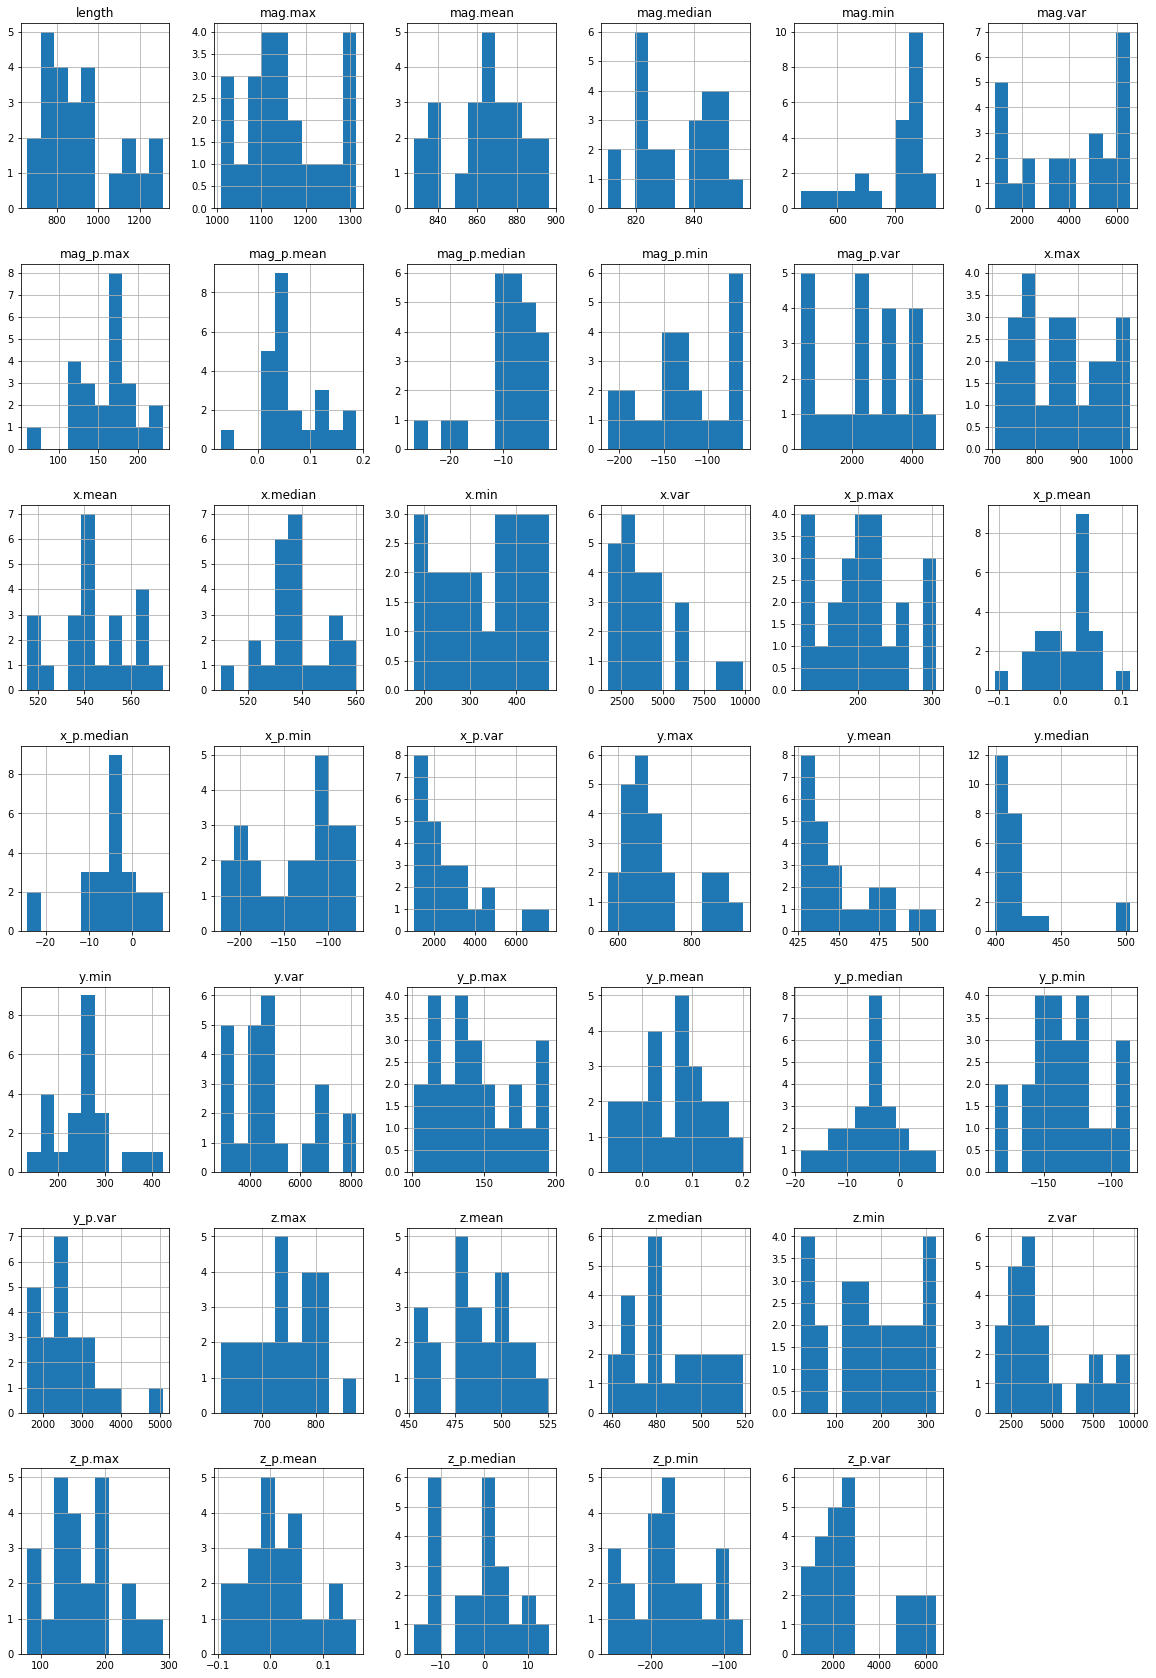

In [5]:
# plots histograms of all features for all gesture sets
import pandas as pd

gesture_sets = get_all_gesture_sets() 
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(gesture_sets)
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_num_col = df.pop('trial_num')
fig = df.hist(figsize=(20,30))
#display(df.describe()) # displays descriptive stats for each column (i.e., feature)
#display(df) # displays full table
#display(df.head()) # displays the first five rows
#[x.title.set_size(10) for x in fig.ravel()] change title sizes for each histogram

,gesturer,gesture,trial_num,length,mag_p.mean,x_p.mean,y_p.mean,z_p.mean,mag.mean,x.mean,...,y.max,z.max,mag_p.min,x_p.min,y_p.min,z_p.min,mag.min,x.min,y.min,z.min
0,NicoleGestures_Try1,Clap,0,955,0.173726,0.020016,0.168391,0.095174,896.781611,555.543455,...,865.0,747.0,-129.670176,-79.308732,-130.130757,-170.549548,626.873193,457.0,174.0,47.0
1,NicoleGestures_Try1,Clap,1,1258,0.138584,0.046869,0.122145,0.057816,889.270253,562.896661,...,940.0,798.0,-124.608517,-68.540631,-110.740318,-151.971483,742.973082,471.0,282.0,53.0
2,NicoleGestures_Try1,Clap,2,946,0.186747,0.045359,0.200675,0.054186,882.274334,537.885835,...,853.0,762.0,-112.935779,-106.525854,-120.845144,-247.785227,742.936740,348.0,251.0,33.0
3,NicoleGestures_Try1,Clap,3,1310,0.114068,0.057435,0.097257,0.027281,860.416705,536.182443,...,881.0,814.0,-147.204274,-73.868792,-95.364313,-177.969859,650.743421,399.0,217.0,71.0
4,NicoleGestures_Try1,Clap,4,1228,0.120034,0.042690,0.115198,0.029085,868.437610,542.150651,...,896.0,798.0,-116.149324,-85.545424,-105.486862,-197.671904,745.582993,438.0,304.0,23.0


trial_num                                           length  \
                       count mean       std  min   25%  50%   75%  max  count   
gesture                                                                         
Clap                     5.0  2.0  1.581139  0.0  1.00  2.0  3.00  4.0    5.0   
Dont pay Attention       5.0  2.0  1.581139  0.0  1.00  2.0  3.00  4.0    5.0   
Elephant Arm             5.0  2.0  1.581139  0.0  1.00  2.0  3.00  4.0    5.0   
Flip                     4.0  1.5  1.290994  0.0  0.75  1.5  2.25  3.0    4.0   
Pulling                  5.0  2.0  1.581139  0.0  1.00  2.0  3.00  4.0    5.0   

                             ...   y.min        z.min                    \
                       mean  ...     75%    max count   mean        std   
gesture                      ...                                          
Clap                1139.40  ...  282.00  304.0   5.0   45.4  18.514859   
Dont pay Attention   860.60  ...  272.00  273.0   5.0  173.8  85.227343   
Elephant Arm         742.60  ...  186.00  223.0   5.0  178.4  45.823575   
Flip                1087.75  ...  381.75  423.0   4.0  285.0  46.137476   
Pulling              805.40  ...  271.00  302.0   5.0  234.6  61.182514   

                                                         
                      min     25%    50%     75%    max  
gesture                                                  
Clap                 23.0   33.00   47.0   53.00   71.0  
Dont pay Attention   81.0  114.00  173.0  200.00  301.0  
Elephant Arm        136.0  147.00  173.0  183.00  253.0  
Flip                219.0  272.25  298.5  311.25  324.0  
Pulling             142.0  217.00  235.0  284.00  295.0  

[5 rows x 336 columns]

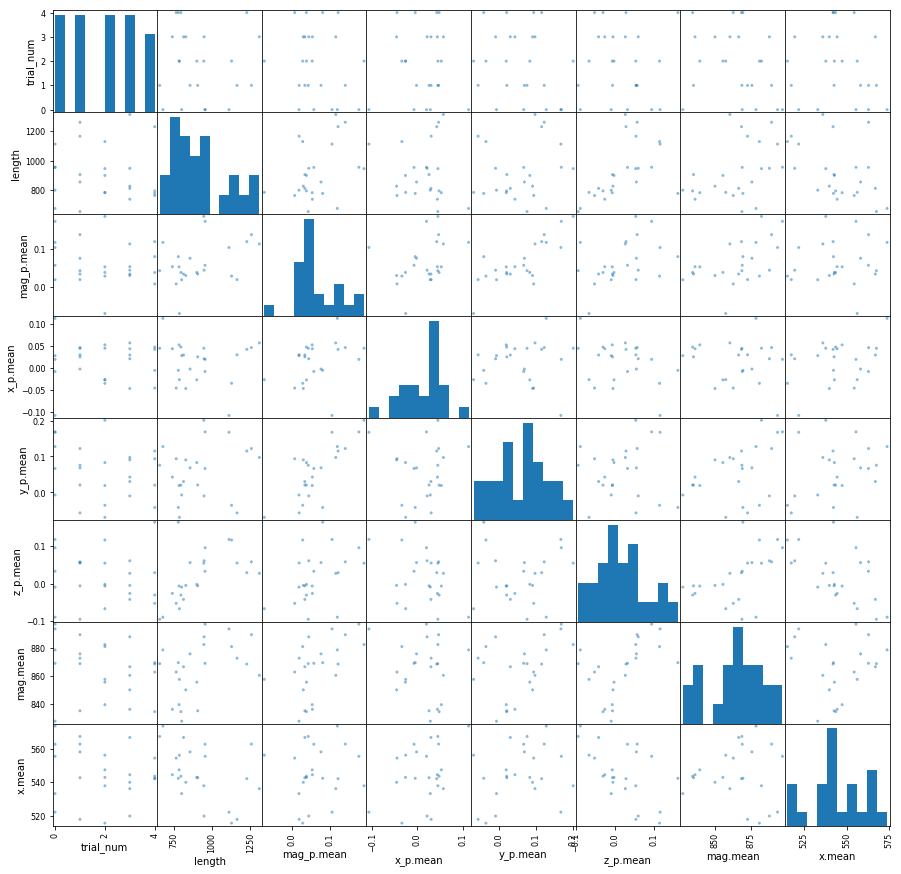

In [7]:
# plot a pairplot (aka scatter_matrix) using pandas
import pandas as pd
from pandas.plotting import scatter_matrix

gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set, include_dummy_data=False)
sorted_gesture_names = sorted(gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

display(df.head())

display(df.groupby('gesture').describe()) # group by gesture and get descriptive stats

# trial_indices = df.pop("trial_num")
# y = df.pop('gesture')
# gesturer = df.pop('gesturer')

df_subset = df.iloc[:,0:10] #[select all rows, only columns 0 through 10]
scatter_matrix(df_subset, figsize=(15,15))
print()

,gesturer,gesture,trial_num,length,mag_p.mean,x_p.mean,y_p.mean,z_p.mean,mag.mean,x.mean,...,y.max,z.max,mag_p.min,x_p.min,y_p.min,z_p.min,mag.min,x.min,y.min,z.min
0,NicoleGestures_Try1,Clap,0,955,0.173726,0.020016,0.168391,0.095174,896.781611,555.543455,...,865.0,747.0,-129.670176,-79.308732,-130.130757,-170.549548,626.873193,457.0,174.0,47.0
1,NicoleGestures_Try1,Clap,1,1258,0.138584,0.046869,0.122145,0.057816,889.270253,562.896661,...,940.0,798.0,-124.608517,-68.540631,-110.740318,-151.971483,742.973082,471.0,282.0,53.0
2,NicoleGestures_Try1,Clap,2,946,0.186747,0.045359,0.200675,0.054186,882.274334,537.885835,...,853.0,762.0,-112.935779,-106.525854,-120.845144,-247.785227,742.936740,348.0,251.0,33.0
3,NicoleGestures_Try1,Clap,3,1310,0.114068,0.057435,0.097257,0.027281,860.416705,536.182443,...,881.0,814.0,-147.204274,-73.868792,-95.364313,-177.969859,650.743421,399.0,217.0,71.0
4,NicoleGestures_Try1,Clap,4,1228,0.120034,0.042690,0.115198,0.029085,868.437610,542.150651,...,896.0,798.0,-116.149324,-85.545424,-105.486862,-197.671904,745.582993,438.0,304.0,23.0


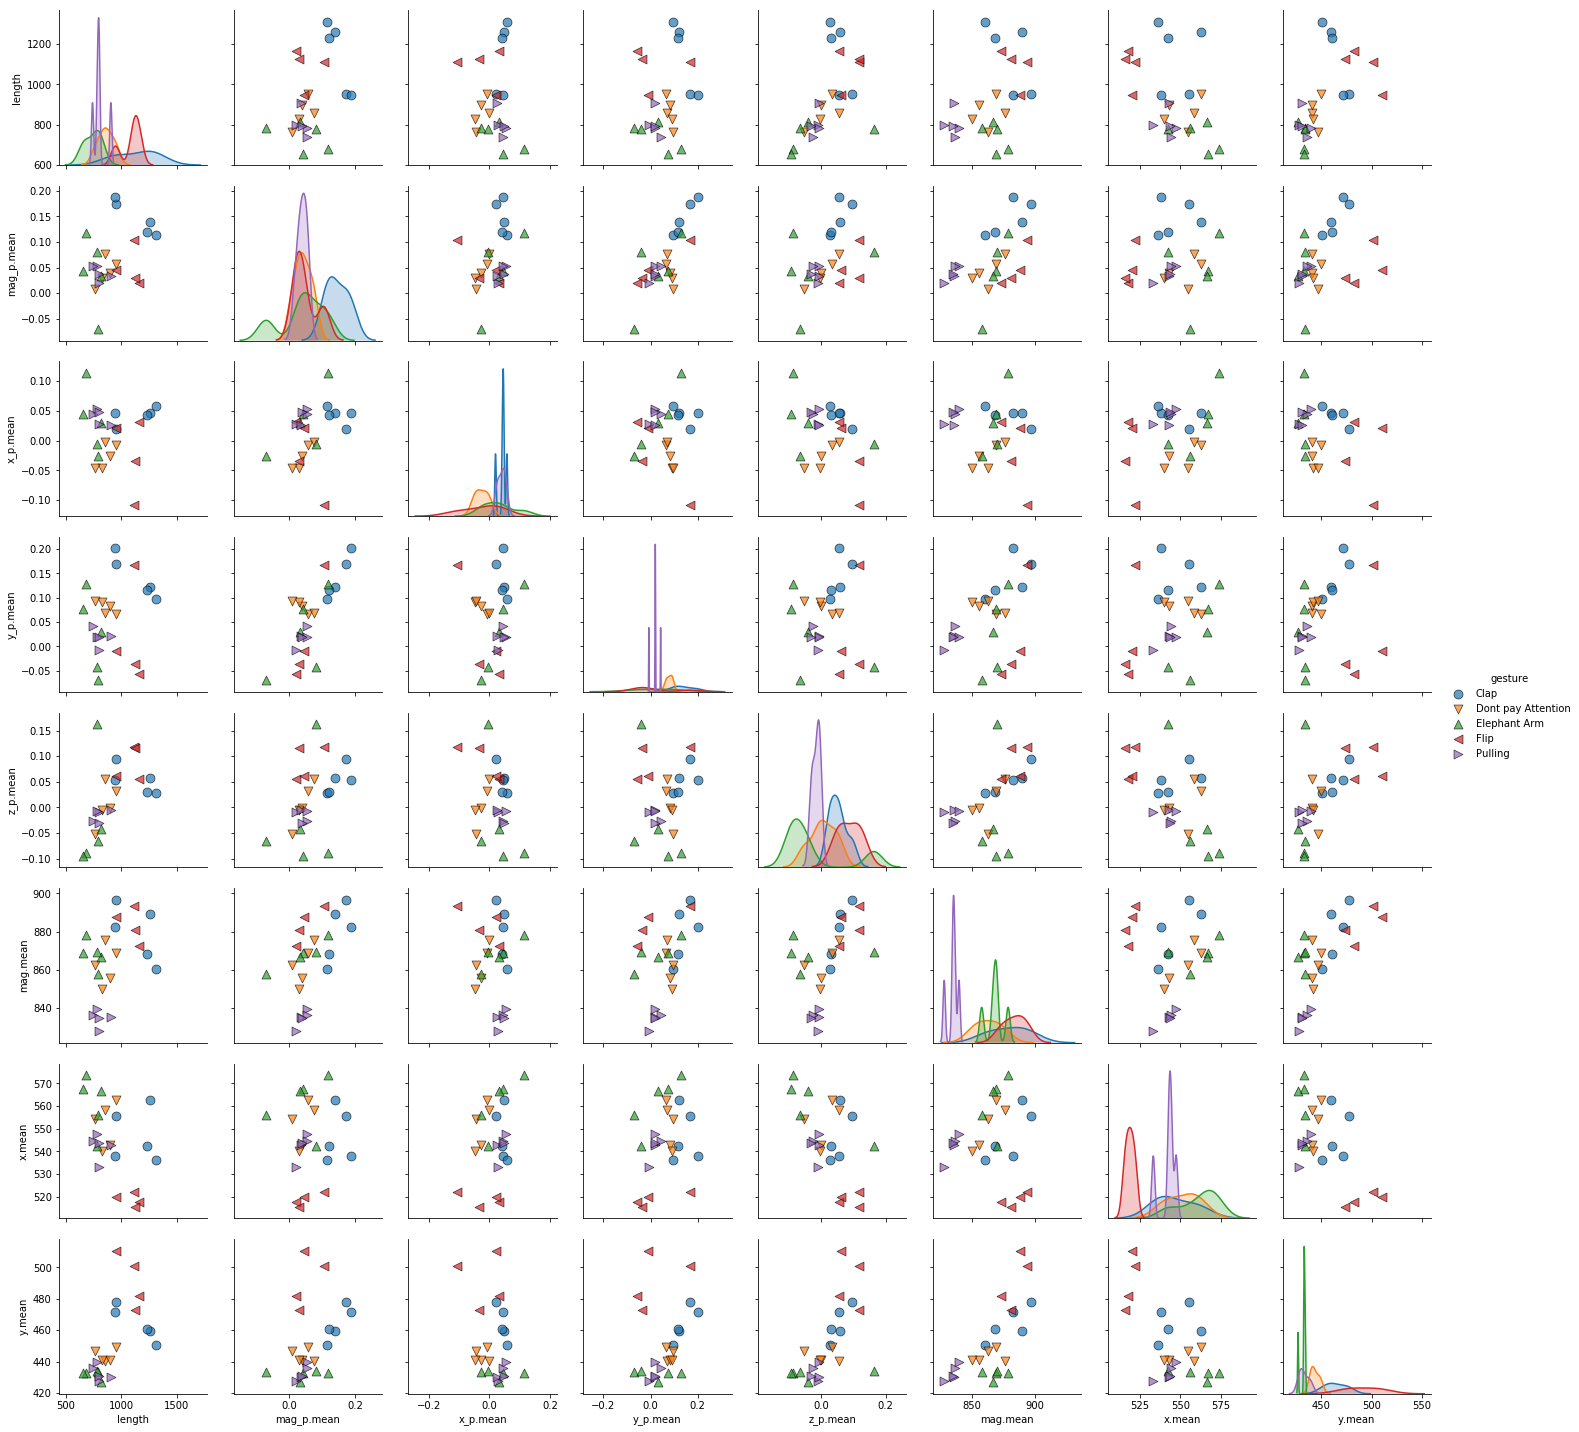

In [8]:
# we can also make prettier pairplots easily with seaborn, which is a 
# Python data visualization library based on matplotlib. Essentially, people use it to make
# prettier plots :)
# See:
# - https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
# - https://seaborn.pydata.org/generated/seaborn.pairplot.html

import pandas as pd
import seaborn as sns

gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set, include_dummy_data=False)
sorted_gesture_names = sorted(gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']
markers = markers[:len(gesture_set.map_gestures_to_trials)]

display(df.head())

# our dataframe is huge, in order to create a pair plot, we need to select certain columns to visualize
# See: https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
trial_col = df.pop('trial_num') # we don't need the trial number in our scatter plot
df_subset = df.iloc[:, 0:10] # play around with different df subsets, must include the gesture column

# by setting hue='gesture', we can color code our scatter plot by gesture name
g = sns.pairplot(df_subset, hue="gesture", 
                 plot_kws = {'alpha': 0.7, 's': 80, 'edgecolor': 'k'}, 
                 markers = markers)

## Cross Correlation

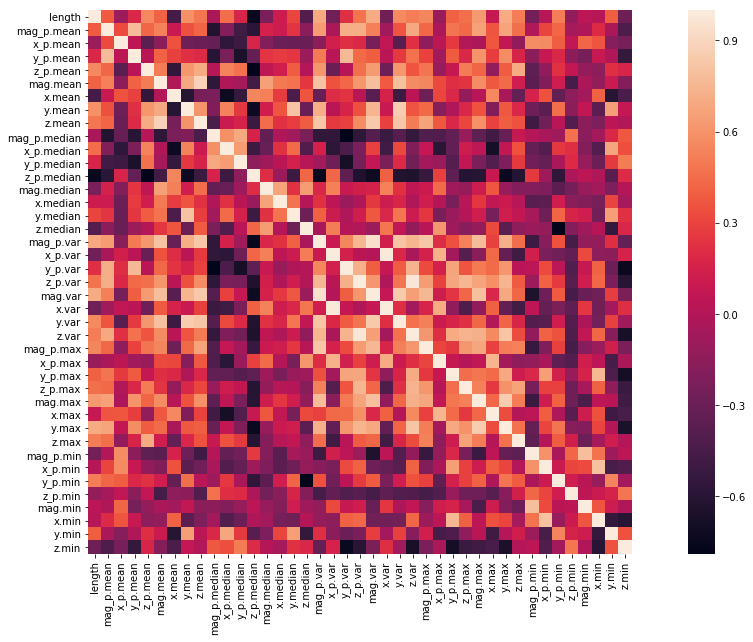

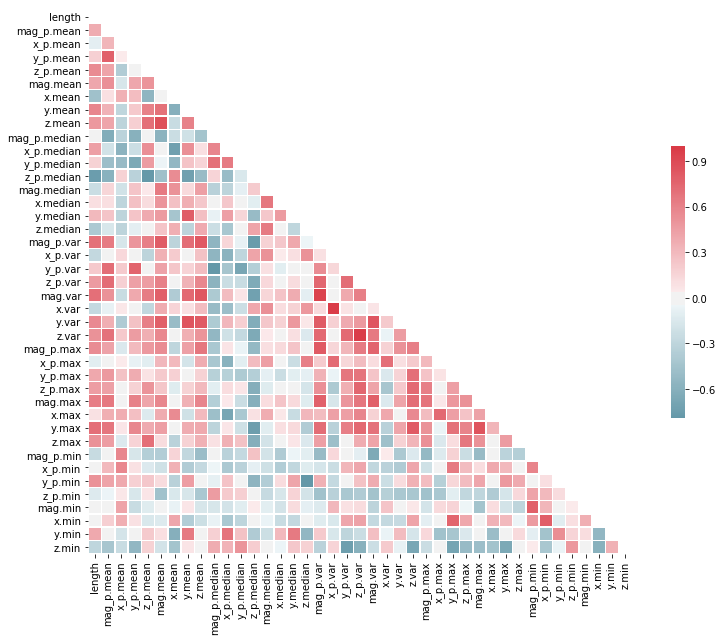

In [10]:
import pandas as pd
import seaborn as sns

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
#display(df)
trial_indices = df.pop("trial_num")
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# Plot the correlation matrix using seaborn
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), square=True)

# Plot a "pretty" version of the correlation matrix 
# Based on: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
import seaborn as sns
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Variance Threshold

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html
# The default is to keep all features with non-zero variance -- that is,
# remove the features that have the same value in all samples.
# You can change this threshold
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

In [12]:
# Feature selection using variance:
# See:
# - https://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True)                                                                           

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # pop off the trial numbers
X = df # set X to the dataframe
y = df.pop('gesture') # pop off the class labels
gesturer = df.pop('gesturer') # pop off the gesturer

# create a train/test set with 80% training, 20% test with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# feature selection using VarianceThreshold
select = VarianceThreshold() 
select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)

# transform test data using the selector
X_test_selected = select.transform(X_test)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(clf.score(X_test, y_test)))

clf.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    clf.score(X_test_selected, y_test)))


Score with all features: 1.000
Score with only selected features: 1.000


11          Elephant Arm
19               Pulling
18                  Flip
5     Dont pay Attention
0                   Clap
Name: gesture, dtype: object
X_train.shape: (19, 47)
X_train_selected.shape: (19, 45)
[ True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
47 Index(['length', 'dummy_always15', 'dummy_always999', 'dummy_0or40_50%split',
       'dummy_0or100_90%split', 'dummy_randint(1,101)', 'dummy_gauss(100, 15)',
       'mag_p.mean', 'x_p.mean', 'y_p.mean', 'z_p.mean', 'mag.mean', 'x.mean',
       'y.mean', 'z.mean', 'mag_p.median', 'x_p.median', 'y_p.median',
       'z_p.median', 'mag.median', 'x.median', 'y.median', 'z.median',
       'mag_p.var', 'x_p.var', 'y_p.var', 'z_p.var', 'mag.var', 'x.var',
       'y.var', 'z.var', 'mag_p.max', 'x_p.max'

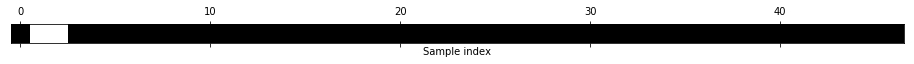

In [13]:
# Same as before but prints more information
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True)                                                                           

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # pop off the trial numbers
X = df # set X to the dataframe
y = df.pop('gesture') # pop off the class labels
gesturer = df.pop('gesturer') # pop off the gesturer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html
select = VarianceThreshold() 
select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# visualize the mask -- black is True, white is False
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

# transform test data using the selector
X_test_selected = select.transform(X_test)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(clf.score(X_test, y_test)))

clf.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    clf.score(X_test_selected, y_test)))


## Univariate Feature Selection
Univariate feature selection works by selecting the best features based on univariate statistical tests ([link](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)). 

In [15]:
# Feature selection using univariate statistics
# This should be much better at identifying the random features
# See Section 4.7.1 in Mueller's book:
#  - https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # pop off the trial numbers
X = df # set X to the dataframe
y = df.pop('gesture') # pop off the class labels
gesturer = df.pop('gesturer') # pop off the gesturer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Scale data first
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# use f_classif (the default) and SelectPercentile to select some % of features
select = SelectPercentile(percentile=90)
select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)

# transform test data
X_test_selected = select.transform(X_test)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(clf.score(X_test, y_test)))

clf.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    clf.score(X_test_selected, y_test)))

Score with all features: 1.000
Score with only selected features: 1.000


/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [1 2] are constant.
  UserWarning)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


6     Dont pay Attention
3                   Clap
22               Pulling
15                  Flip
14          Elephant Arm
Name: gesture, dtype: object
X_train.shape: (19, 47)
X_train_selected.shape: (19, 42)
[ True False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
47 Index(['length', 'dummy_always15', 'dummy_always999', 'dummy_0or40_50%split',
       'dummy_0or100_90%split', 'dummy_randint(1,101)', 'dummy_gauss(100, 15)',
       'mag_p.mean', 'x_p.mean', 'y_p.mean', 'z_p.mean', 'mag.mean', 'x.mean',
       'y.mean', 'z.mean', 'mag_p.median', 'x_p.median', 'y_p.median',
       'z_p.median', 'mag.median', 'x.median', 'y.median', 'z.median',
       'mag_p.var', 'x_p.var', 'y_p.var', 'z_p.var', 'mag.var', 'x.var',
       'y.var', 'z.var', 'mag_p.max', 'x_p.max'

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [1 2] are constant.
  UserWarning)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


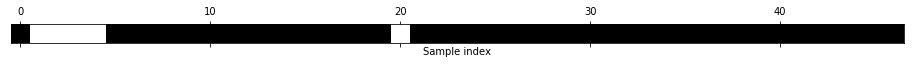

In [16]:
# Feature selection using univariate statistics
# This should be much better at identifying the random features
# See Section 4.7.1 in Mueller's book:
#  - https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # pop off the trial numbers
X = df # set X to the dataframe
y = df.pop('gesture') # pop off the class labels
gesturer = df.pop('gesturer') # pop off the gesturer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# Scale data first
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# use f_classif (the default) and SelectPercentile to select some % of features
# f_classif: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
select = SelectPercentile(percentile=90)
select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# visualize the mask -- black is True, white is False
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

# transform test data
X_test_selected = select.transform(X_test)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(clf.score(X_test, y_test)))

clf.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    clf.score(X_test_selected, y_test)))

## Recursive Feature Elimination
Recursive feature elimination (RFE) selects features by recursively considering smaller and smaller sets of features ([link](https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination)). First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

13          Elephant Arm
16                  Flip
7     Dont pay Attention
21               Pulling
4                   Clap
Name: gesture, dtype: object
[ True False False  True False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True]
[1 6 5 1 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1]
47 Index(['length', 'dummy_always15', 'dummy_always999', 'dummy_0or40_50%split',
       'dummy_0or100_90%split', 'dummy_randint(1,101)', 'dummy_gauss(100, 15)',
       'mag_p.mean', 'x_p.mean', 'y_p.mean', 'z_p.mean', 'mag.mean', 'x.mean',
       'y.mean', 'z.mean', 'mag_p.median', 'x_p.median', 'y_p.median',
       'z_p.median', 'mag.median', 'x.median', 'y.median', 'z.median',
       'mag_p.var', 'x_p.var', 'y_p.var', 'z_p.var', 'mag.var', 'x.var',
       

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


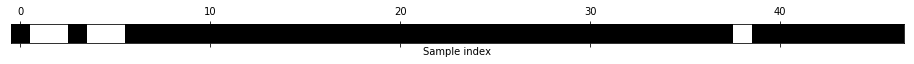

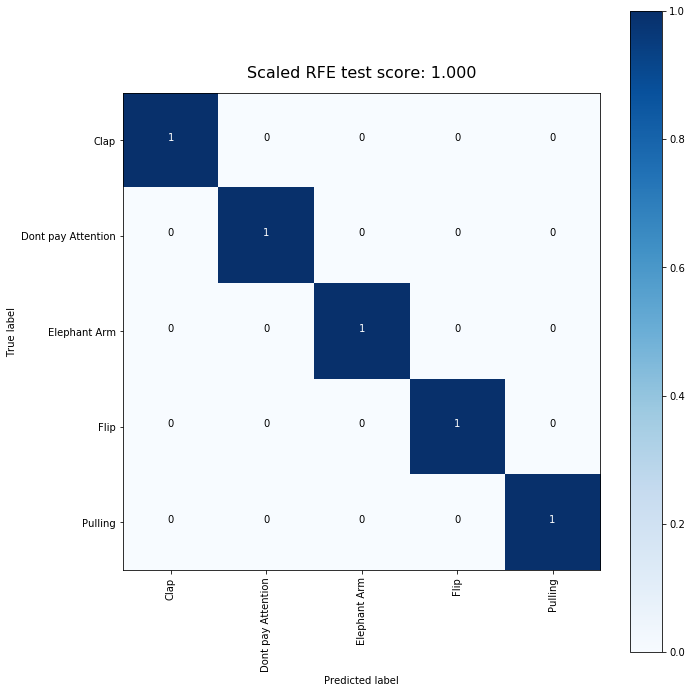

In [17]:
# Feature selection using Recursive Feature Elimination
# - See Section 4.7.3 of the Mueller book: 
#     https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html
# - look a this pipeline article: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
# TODO: one issue is that we are learning parameters on the whole training set, this isn't so good

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set,
                                                                            include_dummy_data=True) 

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 80/20 split with stratification
# in this case, we have 11 gestures x 5 samples = 55 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42
print(y_test)
sorted_gesture_names = sorted(y_train.unique())

# Scale values
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = svm.SVC(kernel='linear')

# see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
num_features_to_eliminate = 5
selector = RFE(clf, n_features_to_select=len(X.columns) - num_features_to_eliminate)
selector.fit(X_train_scaled, y_train)

# visualize the selected features:
mask = selector.get_support()
print(mask)
print(selector.ranking_)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

X_train_scaled_rfe = selector.transform(X_train_scaled)
X_test_scaled_rfe = selector.transform(X_test_scaled)

score = clf.fit(X_train, y_train).score(X_test, y_test)
print("Unscaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)
print("Scaled test score: {:.3f}".format(score))
score = clf.fit(X_train_scaled_rfe, y_train).score(X_test_scaled_rfe, y_test)
print("Scaled RFE test score: {:.3f}".format(score))

y_pred = clf.fit(X_train_scaled_rfe, y_train).predict(X_test_scaled_rfe)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="Scaled RFE test score: {:.3f}".format(score))
plt.show()

feature counts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 48]
RUNNING RFE EXPERIMENTS ON NicoleGestures_Try1


/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

1 FEATURES :  54.00% (SD=9.17%)
	FEATURES USED:
	mag.var : (10/20) 50.0%
	mag_p.min : (4/20) 20.0%
	z.var : (3/20) 15.0%
	y.max : (1/20) 5.0%
	y.var : (1/20) 5.0%
	x_p.min : (1/20) 5.0%
	FEATURES DISCARDED:
	length : (20/20) 100.0%
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	x.median : (20/20) 100.0%
	y.median : (20/20) 100.0%
	z.median : (20/20) 100.0%
	mag_p.var : (20/20) 100.0%
	x_p.var : (20/20) 100.0%
	y_p.var : (20/20) 100.0%
	z_p.var : (20/20) 100.0

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

2 FEATURES :  63.00% (SD=9.54%)
	FEATURES USED:
	mag_p.min : (12/20) 60.0%
	mag.var : (10/20) 50.0%
	y.var : (5/20) 25.0%
	x_p.min : (3/20) 15.0%
	z.var : (2/20) 10.0%
	z_p.var : (2/20) 10.0%
	y.max : (2/20) 10.0%
	y_p.max : (1/20) 5.0%
	x_p.max : (1/20) 5.0%
	x.mean : (1/20) 5.0%
	y.mean : (1/20) 5.0%
	FEATURES DISCARDED:
	length : (20/20) 100.0%
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	z.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	x.median : (20/20) 100.0%
	y.median : (20/20) 100.0%
	z.median : (20/20) 100.0%
	mag_p.var : (20/20) 100.0%
	x_p.var

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

3 FEATURES :  75.00% (SD=13.96%)
	FEATURES USED:
	mag_p.min : (12/20) 60.0%
	y.var : (10/20) 50.0%
	y.max : (9/20) 45.0%
	x_p.min : (7/20) 35.0%
	mag.var : (6/20) 30.0%
	y_p.max : (3/20) 15.0%
	x_p.max : (3/20) 15.0%
	z.median : (2/20) 10.0%
	y.min : (2/20) 10.0%
	x.mean : (2/20) 10.0%
	y.mean : (1/20) 5.0%
	z.var : (1/20) 5.0%
	z_p.var : (1/20) 5.0%
	z.mean : (1/20) 5.0%
	FEATURES DISCARDED:
	length : (20/20) 100.0%
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	x.median : (20/20) 100.0%
	y.median : (20/20) 100.0%
	mag_p.var : (20/

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

4 FEATURES :  83.00% (SD=14.53%)
	FEATURES USED:
	mag_p.min : (13/20) 65.0%
	mag.var : (9/20) 45.0%
	x_p.min : (8/20) 40.0%
	y.max : (7/20) 35.0%
	y.var : (7/20) 35.0%
	x_p.max : (7/20) 35.0%
	y_p.max : (4/20) 20.0%
	y.min : (4/20) 20.0%
	x.mean : (3/20) 15.0%
	y.mean : (3/20) 15.0%
	z.mean : (2/20) 10.0%
	mag_p.var : (2/20) 10.0%
	z.median : (2/20) 10.0%
	z_p.var : (1/20) 5.0%
	z_p.median : (1/20) 5.0%
	x.min : (1/20) 5.0%
	mag.min : (1/20) 5.0%
	z.var : (1/20) 5.0%
	x_p.var : (1/20) 5.0%
	length : (1/20) 5.0%
	z_p.min : (1/20) 5.0%
	z.min : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

5 FEATURES :  90.00% (SD=10.00%)
	FEATURES USED:
	mag_p.min : (20/20) 100.0%
	y.var : (10/20) 50.0%
	x.mean : (9/20) 45.0%
	mag.var : (9/20) 45.0%
	y.max : (9/20) 45.0%
	x_p.min : (7/20) 35.0%
	z_p.var : (6/20) 30.0%
	x_p.max : (6/20) 30.0%
	y_p.max : (6/20) 30.0%
	y.min : (6/20) 30.0%
	y_p.mean : (2/20) 10.0%
	z.median : (2/20) 10.0%
	z_p.min : (1/20) 5.0%
	z.mean : (1/20) 5.0%
	z_p.mean : (1/20) 5.0%
	y.mean : (1/20) 5.0%
	z_p.median : (1/20) 5.0%
	mag_p.var : (1/20) 5.0%
	length : (1/20) 5.0%
	z.var : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	x.median : (20/20) 100.0%
	y.me

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

6 FEATURES :  91.00% (SD=9.95%)
	FEATURES USED:
	mag_p.min : (20/20) 100.0%
	mag.var : (13/20) 65.0%
	x_p.min : (11/20) 55.0%
	y.var : (11/20) 55.0%
	x_p.max : (11/20) 55.0%
	z.median : (7/20) 35.0%
	y.max : (7/20) 35.0%
	y.min : (7/20) 35.0%
	x.mean : (5/20) 25.0%
	z_p.var : (5/20) 25.0%
	length : (5/20) 25.0%
	y_p.max : (4/20) 20.0%
	y.mean : (4/20) 20.0%
	z.min : (4/20) 20.0%
	y_p.mean : (2/20) 10.0%
	z.var : (2/20) 10.0%
	z.mean : (1/20) 5.0%
	mag.max : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	x.median : (20/20) 100.

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

7 FEATURES :  92.00% (SD=11.66%)
	FEATURES USED:
	mag_p.min : (19/20) 95.0%
	mag.var : (15/20) 75.0%
	x_p.max : (13/20) 65.0%
	x_p.min : (12/20) 60.0%
	y_p.max : (11/20) 55.0%
	y.min : (10/20) 50.0%
	y.mean : (8/20) 40.0%
	x.mean : (8/20) 40.0%
	z.median : (7/20) 35.0%
	y.var : (6/20) 30.0%
	y.max : (6/20) 30.0%
	z.mean : (5/20) 25.0%
	z_p.var : (5/20) 25.0%
	z.var : (4/20) 20.0%
	mag.mean : (3/20) 15.0%
	length : (2/20) 10.0%
	y_p.mean : (2/20) 10.0%
	mag_p.var : (1/20) 5.0%
	x_p.var : (1/20) 5.0%
	mag.min : (1/20) 5.0%
	z.min : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.m

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

8 FEATURES :  95.00% (SD=8.66%)
	FEATURES USED:
	mag_p.min : (20/20) 100.0%
	x_p.max : (16/20) 80.0%
	x_p.min : (14/20) 70.0%
	mag.var : (13/20) 65.0%
	y.min : (12/20) 60.0%
	z.median : (10/20) 50.0%
	y.var : (10/20) 50.0%
	x.mean : (10/20) 50.0%
	y_p.max : (9/20) 45.0%
	y.mean : (8/20) 40.0%
	z_p.var : (8/20) 40.0%
	length : (7/20) 35.0%
	z.var : (6/20) 30.0%
	y.max : (5/20) 25.0%
	mag.mean : (4/20) 20.0%
	mag_p.var : (3/20) 15.0%
	z.mean : (2/20) 10.0%
	z.min : (1/20) 5.0%
	x_p.var : (1/20) 5.0%
	y_p.mean : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

9 FEATURES :  98.00% (SD=6.00%)
	FEATURES USED:
	mag_p.min : (20/20) 100.0%
	mag.var : (17/20) 85.0%
	x_p.min : (17/20) 85.0%
	x_p.max : (15/20) 75.0%
	y.min : (14/20) 70.0%
	z.median : (13/20) 65.0%
	x.mean : (13/20) 65.0%
	y.var : (11/20) 55.0%
	y_p.max : (10/20) 50.0%
	y.max : (10/20) 50.0%
	y.mean : (8/20) 40.0%
	z.var : (7/20) 35.0%
	z_p.var : (7/20) 35.0%
	length : (5/20) 25.0%
	mag.mean : (3/20) 15.0%
	z.min : (3/20) 15.0%
	mag.min : (2/20) 10.0%
	y_p.min : (1/20) 5.0%
	z.max : (1/20) 5.0%
	z_p.min : (1/20) 5.0%
	z.mean : (1/20) 5.0%
	y_p.mean : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median 

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

10 FEATURES :  98.00% (SD=6.00%)
	FEATURES USED:
	mag_p.min : (20/20) 100.0%
	x.mean : (18/20) 90.0%
	x_p.max : (17/20) 85.0%
	x_p.min : (17/20) 85.0%
	y.var : (14/20) 70.0%
	y_p.max : (13/20) 65.0%
	y.min : (12/20) 60.0%
	mag.var : (12/20) 60.0%
	y.max : (11/20) 55.0%
	z.median : (10/20) 50.0%
	y.mean : (9/20) 45.0%
	z_p.var : (9/20) 45.0%
	length : (8/20) 40.0%
	z.var : (7/20) 35.0%
	y_p.mean : (5/20) 25.0%
	z.mean : (3/20) 15.0%
	mag.mean : (3/20) 15.0%
	mag_p.var : (3/20) 15.0%
	x_p.var : (2/20) 10.0%
	z_p.min : (2/20) 10.0%
	z.max : (1/20) 5.0%
	mag.max : (1/20) 5.0%
	z_p.mean : (1/20) 5.0%
	z.min : (1/20) 5.0%
	y_p.min : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20)

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

15 FEATURES :  100.00% (SD=0.00%)
	FEATURES USED:
	y.var : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	mag_p.min : (20/20) 100.0%
	x_p.min : (20/20) 100.0%
	y.min : (20/20) 100.0%
	x.mean : (19/20) 95.0%
	mag.var : (19/20) 95.0%
	y_p.max : (19/20) 95.0%
	y.mean : (18/20) 90.0%
	z.median : (18/20) 90.0%
	y.max : (15/20) 75.0%
	z_p.min : (15/20) 75.0%
	mag.min : (14/20) 70.0%
	length : (11/20) 55.0%
	z.var : (11/20) 55.0%
	z_p.var : (9/20) 45.0%
	z.mean : (9/20) 45.0%
	z.min : (6/20) 30.0%
	mag.mean : (3/20) 15.0%
	y_p.mean : (3/20) 15.0%
	y_p.min : (3/20) 15.0%
	x.min : (2/20) 10.0%
	x_p.var : (2/20) 10.0%
	x.var : (1/20) 5.0%
	mag_p.var : (1/20) 5.0%
	x.max : (1/20) 5.0%
	x_p.median : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 10

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

20 FEATURES :  97.00% (SD=7.14%)
	FEATURES USED:
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z_p.var : (20/20) 100.0%
	mag.var : (20/20) 100.0%
	y.var : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	y_p.max : (20/20) 100.0%
	y.max : (20/20) 100.0%
	mag_p.min : (20/20) 100.0%
	x_p.min : (20/20) 100.0%
	z.median : (19/20) 95.0%
	y.min : (19/20) 95.0%
	length : (18/20) 90.0%
	z_p.min : (18/20) 90.0%
	mag.min : (18/20) 90.0%
	z.var : (16/20) 80.0%
	z.mean : (15/20) 75.0%
	y_p.mean : (9/20) 45.0%
	x_p.var : (8/20) 40.0%
	z.min : (8/20) 40.0%
	mag.mean : (8/20) 40.0%
	mag_p.var : (8/20) 40.0%
	x.min : (7/20) 35.0%
	x_p.median : (6/20) 30.0%
	y_p.min : (5/20) 25.0%
	z.max : (4/20) 20.0%
	z_p.mean : (3/20) 15.0%
	x_p.mean : (3/20) 15.0%
	mag.max : (2/20) 10.0%
	x.max : (2/20) 10.0%
	x.var : (1/20) 5.0%
	y_p.median : (1/20) 5.0%
	dummy_0or40_50%split : (1/20) 5.0%
	dummy_gauss(100, 15) : (1/20) 5.0%
	FEATURES DISCARDED:
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dumm

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

25 FEATURES :  99.00% (SD=4.36%)
	FEATURES USED:
	mag.mean : (20/20) 100.0%
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z.median : (20/20) 100.0%
	z_p.var : (20/20) 100.0%
	mag.var : (20/20) 100.0%
	y.var : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	y_p.max : (20/20) 100.0%
	mag_p.min : (20/20) 100.0%
	x_p.min : (20/20) 100.0%
	z_p.min : (20/20) 100.0%
	mag.min : (20/20) 100.0%
	x.min : (20/20) 100.0%
	y.min : (20/20) 100.0%
	length : (19/20) 95.0%
	z.mean : (19/20) 95.0%
	z.var : (19/20) 95.0%
	y.max : (19/20) 95.0%
	y_p.mean : (18/20) 90.0%
	x_p.var : (17/20) 85.0%
	mag_p.var : (16/20) 80.0%
	z.min : (15/20) 75.0%
	y_p.min : (10/20) 50.0%
	x_p.median : (9/20) 45.0%
	x.var : (7/20) 35.0%
	x_p.mean : (7/20) 35.0%
	mag.max : (5/20) 25.0%
	mag_p.mean : (4/20) 20.0%
	x.max : (4/20) 20.0%
	z_p.median : (3/20) 15.0%
	z_p.mean : (2/20) 10.0%
	z.max : (2/20) 10.0%
	x.median : (2/20) 10.0%
	y_p.median : (1/20) 5.0%
	dummy_0or40_50%split : (1/20) 5.0%
	dummy_randint(1,101) : (1/20) 5.0%
	

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

30 FEATURES :  95.00% (SD=8.66%)
	FEATURES USED:
	length : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z.mean : (20/20) 100.0%
	z.median : (20/20) 100.0%
	mag_p.var : (20/20) 100.0%
	x_p.var : (20/20) 100.0%
	z_p.var : (20/20) 100.0%
	mag.var : (20/20) 100.0%
	y.var : (20/20) 100.0%
	z.var : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	y_p.max : (20/20) 100.0%
	y.max : (20/20) 100.0%
	mag_p.min : (20/20) 100.0%
	x_p.min : (20/20) 100.0%
	z_p.min : (20/20) 100.0%
	mag.min : (20/20) 100.0%
	x.min : (20/20) 100.0%
	y.min : (20/20) 100.0%
	z.min : (20/20) 100.0%
	y_p.mean : (19/20) 95.0%
	mag.max : (18/20) 90.0%
	x.var : (17/20) 85.0%
	x_p.mean : (14/20) 70.0%
	x.max : (14/20) 70.0%
	y_p.min : (13/20) 65.0%
	mag_p.mean : (12/20) 60.0%
	y_p.median : (12/20) 60.0%
	x_p.median : (10/20) 50.0%
	z_p.median : (6/20) 30.0%
	z.max : (6/20) 30.0%
	z_p.mean : (5/20) 25.0%
	mag.median : (3/20) 15.0%
	dummy_randint(1,101) : (3/20) 15.0%
	dummy_gauss(100, 1

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

35 FEATURES :  99.00% (SD=4.36%)
	FEATURES USED:
	length : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z.mean : (20/20) 100.0%
	z.median : (20/20) 100.0%
	mag_p.var : (20/20) 100.0%
	x_p.var : (20/20) 100.0%
	z_p.var : (20/20) 100.0%
	mag.var : (20/20) 100.0%
	x.var : (20/20) 100.0%
	y.var : (20/20) 100.0%
	z.var : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	y_p.max : (20/20) 100.0%
	mag.max : (20/20) 100.0%
	y.max : (20/20) 100.0%
	mag_p.min : (20/20) 100.0%
	x_p.min : (20/20) 100.0%
	z_p.min : (20/20) 100.0%
	mag.min : (20/20) 100.0%
	x.min : (20/20) 100.0%
	y.min : (20/20) 100.0%
	z.min : (20/20) 100.0%
	x_p.median : (19/20) 95.0%
	z_p.median : (19/20) 95.0%
	x.max : (19/20) 95.0%
	y_p.min : (18/20) 90.0%
	y_p.median : (15/20) 75.0%
	mag.median : (12/20) 60.0%
	dummy_gauss(100, 15) : (12/20) 60.0%
	dummy_0or40_50%split : (9/20) 45.0%
	x.median : (9/20) 45

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

40 FEATURES :  99.00% (SD=4.36%)
	FEATURES USED:
	length : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z.mean : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	z.median : (20/20) 100.0%
	mag_p.var : (20/20) 100.0%
	x_p.var : (20/20) 100.0%
	y_p.var : (20/20) 100.0%
	z_p.var : (20/20) 100.0%
	mag.var : (20/20) 100.0%
	x.var : (20/20) 100.0%
	y.var : (20/20) 100.0%
	z.var : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	y_p.max : (20/20) 100.0%
	mag.max : (20/20) 100.0%
	x.max : (20/20) 100.0%
	y.max : (20/20) 100.0%
	mag_p.min : (20/20) 100.0%
	x_p.min : (20/20) 100.0%
	y_p.min : (20/20) 100.0%
	z_p.min : (20/20) 100.0%
	mag.min : (20/20) 100.0%
	x.min : (20/20) 100.0%
	y.min : (20/20) 100.0%
	z.min : (20/20) 100.0%
	z_p.mean : (19/20) 95.0%
	x.median : (18/20) 90.0%
	z_p.max : (

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

45 FEATURES :  96.00% (SD=8.00%)
	FEATURES USED:
	length : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	x.median : (20/20) 100.0%
	y.median : (20/20) 100.0%
	z.median : (20/20) 100.0%
	mag_p.var : (20/20) 100.0%
	x_p.var : (20/20) 100.0%
	y_p.var : (20/20) 100.0%
	z_p.var : (20/20) 100.0%
	mag.var : (20/20) 100.0%
	x.var : (20/20) 100.0%
	y.var : (20/20) 100.0%
	z.var : (20/20) 100.0%
	mag_p.max : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	y_p.max : (20/20) 100.0%
	z_p.max : (20/20) 100.0%
	mag.max : (20/20) 

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rashmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by

48 FEATURES :  98.00% (SD=6.00%)
	FEATURES USED:
	length : (20/20) 100.0%
	dummy_always15 : (20/20) 100.0%
	dummy_always999 : (20/20) 100.0%
	dummy_0or40_50%split : (20/20) 100.0%
	dummy_0or100_90%split : (20/20) 100.0%
	dummy_randint(1,101) : (20/20) 100.0%
	dummy_gauss(100, 15) : (20/20) 100.0%
	mag_p.mean : (20/20) 100.0%
	x_p.mean : (20/20) 100.0%
	y_p.mean : (20/20) 100.0%
	z_p.mean : (20/20) 100.0%
	mag.mean : (20/20) 100.0%
	x.mean : (20/20) 100.0%
	y.mean : (20/20) 100.0%
	z.mean : (20/20) 100.0%
	mag_p.median : (20/20) 100.0%
	x_p.median : (20/20) 100.0%
	y_p.median : (20/20) 100.0%
	z_p.median : (20/20) 100.0%
	mag.median : (20/20) 100.0%
	x.median : (20/20) 100.0%
	y.median : (20/20) 100.0%
	z.median : (20/20) 100.0%
	mag_p.var : (20/20) 100.0%
	x_p.var : (20/20) 100.0%
	y_p.var : (20/20) 100.0%
	z_p.var : (20/20) 100.0%
	mag.var : (20/20) 100.0%
	x.var : (20/20) 100.0%
	y.var : (20/20) 100.0%
	z.var : (20/20) 100.0%
	mag_p.max : (20/20) 100.0%
	x_p.max : (20/20) 100.0%
	y_p

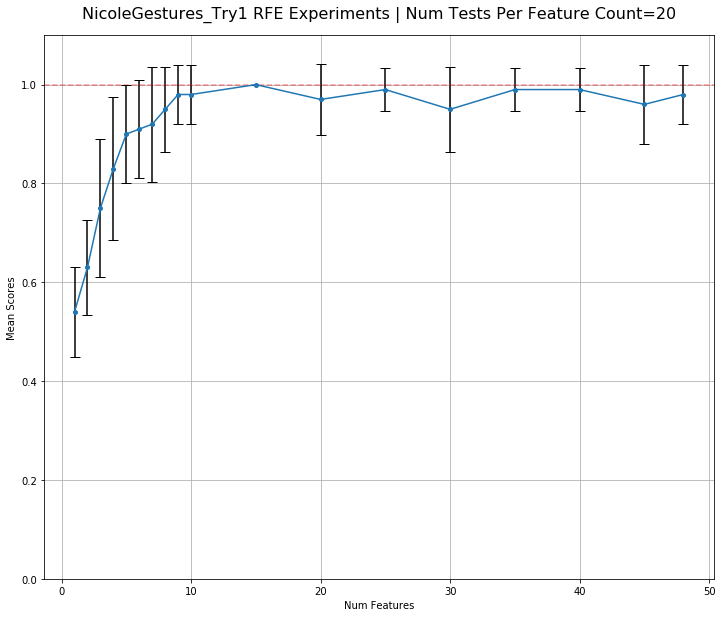

In [18]:
# experiment showing accuracy as a function of num of features
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

def run_rfe_experiment(gesture_set, n_features_to_select, include_dummy_data):
    (list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set,
                                                                                include_dummy_data=include_dummy_data) 

    df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
    trial_indices = df.pop("trial_num")
    X = df
    y = df.pop('gesture')
    gesturer = df.pop('gesturer')

    # 80/20 split with stratification
    # in this case, we have 11 gestures x 5 samples = 55 total
    # so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
    # gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
    sorted_gesture_names = sorted(y_train.unique())

    # Scale values
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf = svm.SVC(kernel='linear', C=0.1)

    # see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
    selector = RFE(clf, n_features_to_select=n_features_to_select)
    selector.fit(X_train_scaled, y_train)
    mask = selector.get_support()
    
    X_train_scaled_rfe = selector.transform(X_train_scaled)
    X_test_scaled_rfe = selector.transform(X_test_scaled)
    score = clf.fit(X_train_scaled_rfe, y_train).score(X_test_scaled_rfe, y_test)

    return { 'score' : score,
             'features_used' : X.columns[mask],
             'features_discarded' : X.columns[~mask] }


def run_varying_feature_count_rfe_experiment(gesture_set, feature_counts, 
                                             num_experiments_to_run_per_feature_cnt = 30,
                                             include_dummy_data = False,
                                             verbose=False):
    
    (list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set,
                                                                                include_dummy_data=include_dummy_data)
    df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
    trial_indices = df.pop("trial_num")
    y = df.pop('gesture')
    gesturer = df.pop('gesturer')
    X = df
    
    total_num_features = len(X.columns)
    map_num_features_score = dict()
    mean_scores = list()
    stdev_scores = list()
    map_num_features_to_features_used_stats = dict() 
    map_num_features_to_features_discarded_stats = dict() 
    for num_features in feature_counts:
        scores = list()
        map_feature_used_to_cnt = dict()
        map_features_discarded_to_cnt = dict()
        for i in range(0, num_experiments_to_run_per_feature_cnt):
            results = run_rfe_experiment(gesture_set, num_features, include_dummy_data)
            scores.append(results['score'])

            features_used = results['features_used']
            for feature_used in features_used:
                if feature_used not in map_feature_used_to_cnt:
                    map_feature_used_to_cnt[feature_used] = 0
                map_feature_used_to_cnt[feature_used] += 1
                
            features_discarded = results['features_discarded']
            for feature_discarded in features_discarded:
                if feature_discarded not in map_features_discarded_to_cnt:
                    map_features_discarded_to_cnt[feature_discarded] = 0
                map_features_discarded_to_cnt[feature_discarded] += 1

        # print(scores)
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        print("{} FEATURES : {: 0.2f}% (SD={:0.2f}%)".format(num_features, mean_score * 100, stdev_score * 100))
        
        if verbose:
            print("\tFEATURES USED:")
            for kvp in sorted(map_feature_used_to_cnt.items(), key=lambda x: x[1], reverse=True):
                print("\t{} : ({}/{}) {:.1f}%".format(kvp[0], kvp[1], num_experiments_to_run_per_feature_cnt,
                                                     (kvp[1] / num_experiments_to_run_per_feature_cnt * 100)))
                
            print("\tFEATURES DISCARDED:")
            for kvp in sorted(map_features_discarded_to_cnt.items(), key=lambda x: x[1], reverse=True):
                print("\t{} : ({}/{}) {:.1f}%".format(kvp[0], kvp[1], num_experiments_to_run_per_feature_cnt,
                                                     (kvp[1] / num_experiments_to_run_per_feature_cnt * 100)))
        
        map_num_features_score[num_features] = mean_score 
        mean_scores.append(mean_score)
        stdev_scores.append(stdev_score)
        map_num_features_to_features_used_stats[num_features] = map_feature_used_to_cnt
        map_num_features_to_features_discarded_stats[num_features] = map_features_discarded_to_cnt

    print(len(mean_scores), mean_scores)
    plt.figure(figsize=(12,10))
    plt.axhline(y=1, color='r', alpha=0.4, linestyle='--')
    plt.errorbar(feature_counts, mean_scores, stdev_scores, ecolor='black', 
                 fmt='-o', markersize=4, capsize=5)
    plt.ylabel('Mean Scores')
    plt.xlabel('Num Features')
    plt.title("{} RFE Experiments | Num Tests Per Feature Count={}".format(gesture_set.get_name(),
                                                                           num_experiments_to_run_per_feature_cnt),
                                                                           fontsize=16, y=1.02)
    plt.ylim((0,1.1))
    plt.grid()
    plt.show()
    return { 'map_num_features_score' : map_num_features_score,
             'map_num_features_to_features_used_stats' : map_num_features_to_features_used_stats,
             'map_num_features_to_features_discarded_stats' : map_num_features_to_features_discarded_stats,
             'mean_scores' : mean_scores,
             'stdev_scores' : stdev_scores,
             'feature_counts' : feature_counts, 
             'num_experiments_ran_per_feature_cnt' : num_experiments_to_run_per_feature_cnt}
 

selected_gesture_set = None
include_dummy_data = True
rand_gesture_set = get_random_gesture_set()
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(rand_gesture_set,
                                                                             include_dummy_data=include_dummy_data)
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
y = df.pop('gesture')
gesturer = df.pop('gesturer')
total_num_features = len(df.columns)
max_num_features = total_num_features + 1

feature_counts = list(range(1, min(10, max_num_features), 1))
if max_num_features > 10:
    feature_counts += list(range(10, max_num_features, 5))
    feature_counts.append(max_num_features)
print("feature counts", feature_counts)

map_gesture_set_name_to_rfe_results = dict()
num_experiments_to_run_per_feature_cnt = 20
for gesture_set in get_all_gesture_sets():
    print("RUNNING RFE EXPERIMENTS ON", gesture_set.get_name())
    result_dict = run_varying_feature_count_rfe_experiment(gesture_set, feature_counts, 
                                                           num_experiments_to_run_per_feature_cnt, verbose=True,
                                                           include_dummy_data=include_dummy_data)
    map_gesture_set_name_to_rfe_results[gesture_set.get_name()] = result_dict

In [ ]:
map_gesture_set_name_to_rfe_results = map_gesture_set_name_to_rfe_results_with_dummy

# visualize aggregate RFE experiment data
plt.figure(figsize=(15,10))
plt.axhline(y=1, color='r', alpha=0.4, linestyle='--')
num_experiments_ran_per_feature_cnt = -1
for gesture_set_name, results_dict in map_gesture_set_name_to_rfe_results.items():
    feature_counts = results_dict['feature_counts']
    mean_scores = results_dict['mean_scores']
    stdev_scores = results_dict['stdev_scores']
    num_experiments_ran_per_feature_cnt = results_dict['num_experiments_ran_per_feature_cnt']
    plt.plot(feature_counts, mean_scores, label=gesture_set_name)
#     plt.errorbar(feature_counts, mean_scores, stdev_scores, ecolor='black', 
#                  fmt='-o', markersize=4, capsize=5, label=gesture_set_name)

plt.ylabel('Mean Scores ({} Runs Per Feature Count)'.format(num_experiments_ran_per_feature_cnt))
plt.xlabel('Num Features')
plt.ylim((0,1.1))
plt.grid()
plt.legend()
plt.show()

# calculate overall scores and stdev for each feature num
map_num_features_score_list = dict()
for gesture_set_name, results_dict in map_gesture_set_name_to_rfe_results.items():
    map_num_features_score = results_dict['map_num_features_score']
    for num_features, score in map_num_features_score.items():
        if num_features not in map_num_features_score_list:
            map_num_features_score_list[num_features] = list()
        map_num_features_score_list[num_features].append(score)

# plot overall accuracy
map_num_features_mean_score = dict()
map_num_features_stdev_score = dict()
overall_mean_scores = list()
overall_stdev_scores = list()
feature_counts = sorted(map_num_features_score_list.keys())
for num_features in feature_counts:
    score_list = map_num_features_score_list[num_features]
    map_num_features_mean_score[num_features] = np.mean(score_list)
    map_num_features_stdev_score[num_features] = np.std(score_list)
    overall_mean_scores.append(np.mean(score_list))
    overall_stdev_scores.append(np.std(score_list))

plt.figure(figsize=(15,10))
plt.errorbar(feature_counts, overall_mean_scores, overall_stdev_scores, ecolor='black', 
             fmt='-o', markersize=4, capsize=5)

# add in annotations
for feature_count in feature_counts:
    if feature_count >= 10:
        mean_score = map_num_features_mean_score[feature_count]
        plt.annotate("{:0.1f}%".format(mean_score * 100), # this is the text
                     (feature_count, mean_score), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(18,8), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

plt.xlabel('Num Features')
plt.ylim((0,1.1))
plt.title("Mean Accuracy as a Function of Feature Count")
plt.grid()
plt.show()

# calculate most common and least common features used
map_num_features_to_map_feature_used_to_overall_cnt = dict()
map_num_features_to_map_feature_discarded_to_overall_cnt = dict()
for gesture_set_name, results_dict in map_gesture_set_name_to_rfe_results.items():
    map_num_features_to_features_used_stats = results_dict['map_num_features_to_features_used_stats']
    for num_features, map_feature_used_to_cnt in map_num_features_to_features_used_stats.items():
        if num_features not in map_num_features_to_map_feature_used_to_overall_cnt:
            map_num_features_to_map_feature_used_to_overall_cnt[num_features] = dict()
        
        map_feature_used_to_overall_cnt = map_num_features_to_map_feature_used_to_overall_cnt[num_features]
        for feature_name, feature_used_cnt in map_feature_used_to_cnt.items():
            if feature_name not in map_feature_used_to_overall_cnt:
                map_feature_used_to_overall_cnt[feature_name] = 0
            
            map_feature_used_to_overall_cnt[feature_name] += feature_used_cnt
            
    map_num_features_to_features_discarded_stats = results_dict['map_num_features_to_features_discarded_stats']
    for num_features, map_feature_discarded_to_cnt in map_num_features_to_features_discarded_stats.items():
        if num_features not in map_num_features_to_map_feature_discarded_to_overall_cnt:
            map_num_features_to_map_feature_discarded_to_overall_cnt[num_features] = dict()
        
        map_feature_discarded_to_overall_cnt = map_num_features_to_map_feature_discarded_to_overall_cnt[num_features]
        for feature_name, feature_discarded_cnt in map_feature_discarded_to_cnt.items():
            if feature_name not in map_feature_discarded_to_overall_cnt:
                map_feature_discarded_to_overall_cnt[feature_name] = 0
            
            map_feature_discarded_to_overall_cnt[feature_name] += feature_discarded_cnt
    

overall_max_num_times_feature_could_be_used = num_experiments_to_run_per_feature_cnt *\
                                                len(map_gesture_set_name_to_rfe_results)
for num_features in feature_counts:
    overall_mean_accuracy = map_num_features_mean_score[num_features]
    overall_stdev_accuracy = map_num_features_stdev_score[num_features]
    print("{} FEATURES: OVERALL ACCURACY {:0.2f}% (SD={:0.2f}%)".format(num_features, 
                                                         overall_mean_accuracy * 100, 
                                                         overall_stdev_accuracy * 100))
    
    print("\tFEATURES USED RATES:")
    map_feature_used_to_overall_cnt = map_num_features_to_map_feature_used_to_overall_cnt[num_features]
    i = 0
    for kvp in sorted(map_feature_used_to_overall_cnt.items(), key=lambda x: x[1], reverse=True):
        print("\t{:02d} {} : ({}/{}) {:.1f}%".format(i, kvp[0], kvp[1], overall_max_num_times_feature_could_be_used,
                                             (kvp[1] / overall_max_num_times_feature_could_be_used * 100)))
        i += 1
        
    print("\tFEATURES DISCARDED RATES")
    i = 0
    map_feature_discarded_to_overall_cnt = map_num_features_to_map_feature_discarded_to_overall_cnt[num_features]
    for kvp in sorted(map_feature_discarded_to_overall_cnt.items(), key=lambda x: x[1], reverse=True):
        print("\t{:02d} {} : ({}/{}) {:.1f}%".format(i, kvp[0], kvp[1], overall_max_num_times_feature_could_be_used,
                                             (kvp[1] / overall_max_num_times_feature_could_be_used * 100)))
        i += 1
    
    
# for gesture_set_name, results_dict in map_gesture_set_name_to_rfe_results.items():
#     feature_counts = results_dict['feature_counts']
#     mean_scores = results_dict['mean_scores']
#     stdev_scores = results_dict['stdev_scores']
    
#     print("{} FEATURES : {: 0.2f}% (SD={:0.2f}%)".format(num_features, mean_score * 100, stdev_score * 100))
        
#         if verbose:
#             print("\tFEATURES USED:")
#             for kvp in sorted(map_feature_to_cnt.items(), key=lambda x: x[1], reverse=True):
#                 print("\t{} : ({}/{}) {:.1f}%".format(kvp[0], kvp[1], num_experiments_to_run_per_feature_cnt,
#                                                      (kvp[1] / num_experiments_to_run_per_feature_cnt * 100)))

In [ ]:
# This example is not yet working
# Trying to use a pipeline with RFECV but it's currently failing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# We need this class due to a problem with RFECV and pipelining
# See: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        print(vars(self.steps[-1][-1]))
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

selected_gesture_set = get_gesture_set_with_str("Annie")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

clf = svm.SVC(kernel='linear')
scaler = StandardScaler()
pipeline = PipelineRFE([('scaler', scaler), ('classifier', clf)])

np.random.seed(5) # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default

# see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
selector = RFECV(pipeline, cv=skf)
selector.fit(X, y)

# visualize the selected features:
mask = selector.get_support()
print(mask)
print(selector.ranking_)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

print(len(X.columns), X.columns)
print(len(X.columns[mask]), X.columns[mask])
print("eliminated vars", X.columns[~mask])

# X_train_scaled_rfe = selector.transform(X_train_scaled)
# X_test_scaled_rfe = selector.transform(X_test_scaled)
# y_pred = cross_val_predict(pipeline, X, y, cv=skf)

# Parameter Tuning

RUNNING JonGesturesEasy
Best parameters: {'estimator__degree': 1, 'estimator__kernel': 'poly'}
Best cross-validation score: 0.98


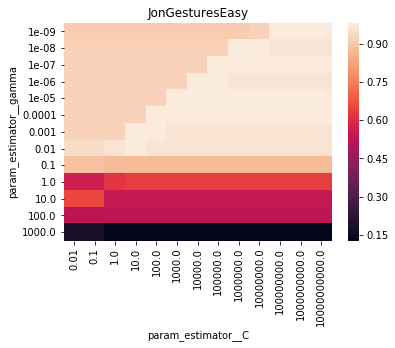

RUNNING CJGestureLogs
Best parameters: {'estimator__C': 0.01, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}
Best cross-validation score: 0.98


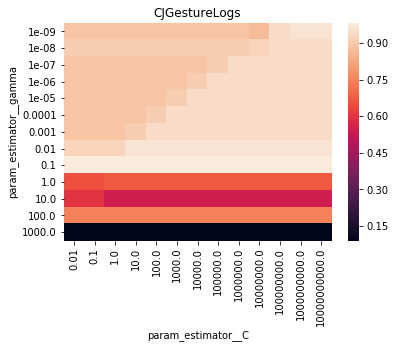

RUNNING EmilyGestures
Best parameters: {'estimator__degree': 1, 'estimator__kernel': 'poly'}
Best cross-validation score: 1.00


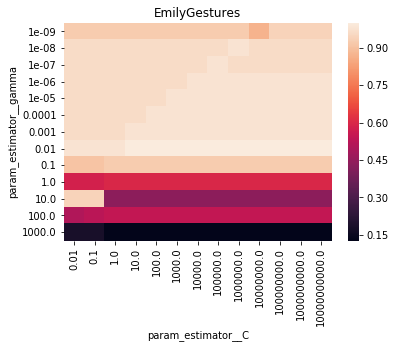

RUNNING StevenGestures
Best parameters: {'estimator__C': 1.0, 'estimator__kernel': 'linear'}
Best cross-validation score: 0.96


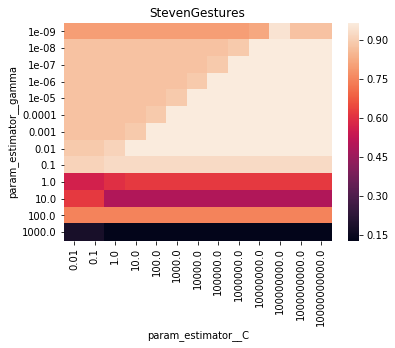

RUNNING AmritaGestureLogs
Best parameters: {'estimator__degree': 1, 'estimator__kernel': 'poly'}
Best cross-validation score: 0.96


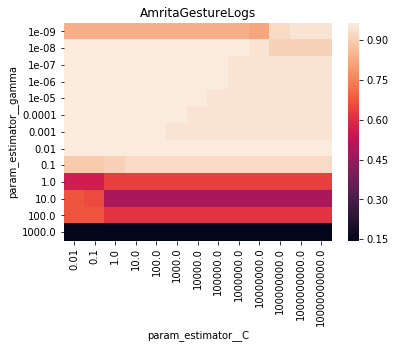

RUNNING MattGestureLogs
Best parameters: {'estimator__C': 1.0, 'estimator__kernel': 'linear'}
Best cross-validation score: 1.00


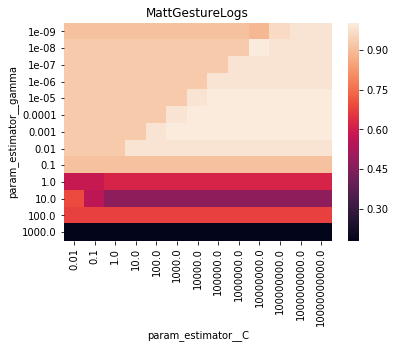

RUNNING EmiliaGestures
Best parameters: {'estimator__degree': 1, 'estimator__kernel': 'poly'}
Best cross-validation score: 1.00


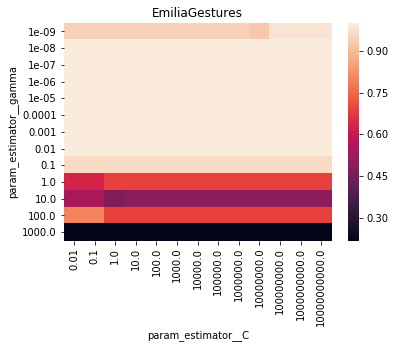

RUNNING EmilyGesturesHard
Best parameters: {'estimator__C': 10000000.0, 'estimator__gamma': 1e-08, 'estimator__kernel': 'rbf'}
Best cross-validation score: 0.98


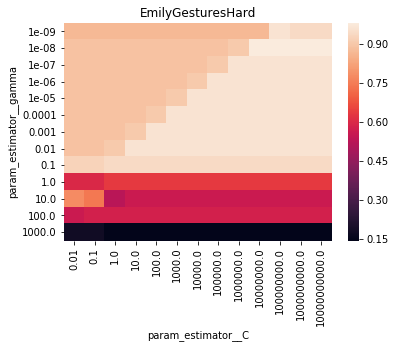

RUNNING JonGesturesHarder
Best parameters: {'estimator__C': 100000000.0, 'estimator__gamma': 1e-08, 'estimator__kernel': 'rbf'}
Best cross-validation score: 0.89


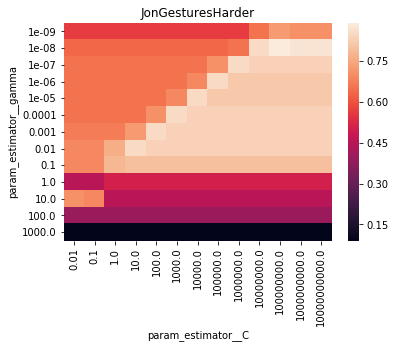

RUNNING AnnieGestureLogs
Best parameters: {'estimator__C': 10.0, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Best cross-validation score: 1.00


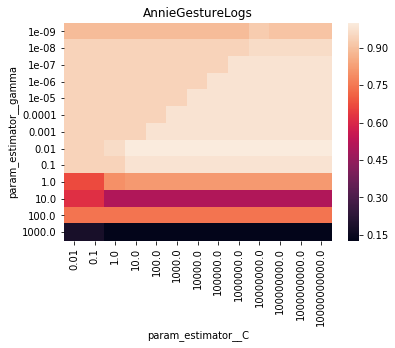

RUNNING YounghoonGestureLogs
Best parameters: {'estimator__degree': 1, 'estimator__kernel': 'poly'}
Best cross-validation score: 1.00


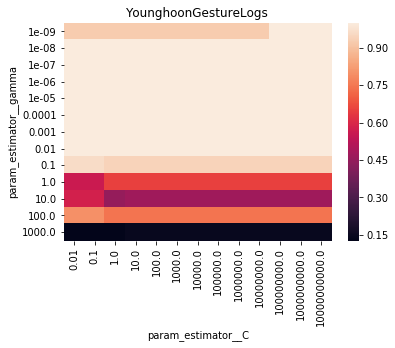

RUNNING RashmiGestures
Best parameters: {'estimator__degree': 1, 'estimator__kernel': 'poly'}
Best cross-validation score: 1.00


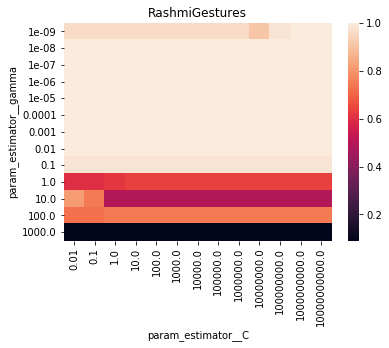

RUNNING JohnGestureLogs
Best parameters: {'estimator__C': 1.0, 'estimator__kernel': 'linear'}
Best cross-validation score: 0.98


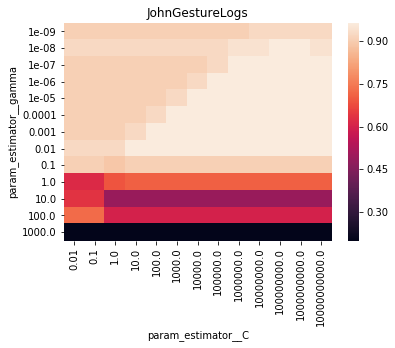

RUNNING NicoleGestures
Best parameters: {'estimator__C': 1.0, 'estimator__kernel': 'linear'}
Best cross-validation score: 0.96


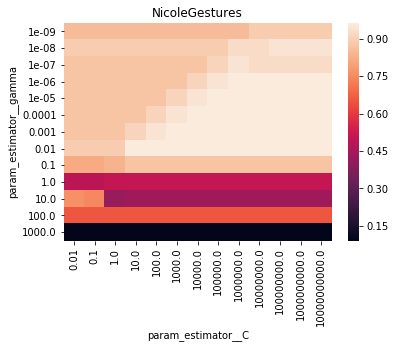

In [8]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def run_svm_parameter_tuning(gesture_set):
    (list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set)
    sorted_gesture_names = sorted(gesture_set.map_gestures_to_trials.keys())

    df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
    trial_indices = df.pop("trial_num") # pop the trial num as that's not an input feature
    X = df
    y = df.pop('gesture') # pop the 'gesture' as that's the ground truth label
    df.pop('gesturer')

    np.random.seed(5) # change this to None to have a different k-fold split on every run
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default

    scaler = StandardScaler() #RobustScaler()
    clf = svm.SVC(kernel='linear')

    # https://datascience.stackexchange.com/a/48155
    pipeline = Pipeline([('transformer', scaler), ('estimator', clf)]) # see https://stackoverflow.com/a/44447786

    # create the param grid, I had to prefix the params by 'estimator__' because we are using a pipeline
    # and so i'm referring to the 'estimator' dict key in the pipeline object above
    
    C_range = np.logspace(-2, 10, 13) # old: [1, 10, 100, 1000, 5000, 10000]
    gamma_range = np.logspace(-9, 3, 13) # old: [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
    
    param_grid = [
      {'estimator__degree': [1, 2, 3, 4], 'estimator__kernel': ['poly']},  
      {'estimator__C': C_range, 'estimator__kernel': ['linear']},
      {'estimator__C': C_range, 'estimator__gamma': gamma_range, 'estimator__kernel': ['rbf']},
     ]

    grid_search = GridSearchCV(pipeline, param_grid, cv=skf, return_train_score=True)
    grid_search.fit(X, y)

    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    #print("Best estimator:\n{}".format(grid_search.best_estimator_))

    # convert to DataFrame to display full results
    results_df = pd.DataFrame(grid_search.cv_results_)
    #display(results_df)
    
    # now visualize as a heatmap
    # see: 
    # - https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
    # - https://datascience.stackexchange.com/a/38673 (had to modify this heavily but it got me started)
    results_df_rbf = results_df[results_df.param_estimator__kernel == 'rbf']
    #display(results_df_rbf)
    results_df_rbf = results_df_rbf[['mean_test_score', 'param_estimator__C', 'param_estimator__gamma']]
    #display(results_df_rbf)
    pivot = pd.pivot_table(results_df_rbf, values='mean_test_score', columns='param_estimator__C', index='param_estimator__gamma') #, values='mean_test_score', index=['mean_test_score', 'param_estimator__C'])
    #display(pivot)
    
    sns.heatmap(pivot)
    plt.title(gesture_set.get_name())
    plt.show()

# Go through all gesture sets and run parameter tuning experiment
for path, gesture_set in map_gesture_sets.items():
    print("RUNNING", path)
    run_svm_parameter_tuning(gesture_set)

# Evaluation Approaches

## 80/20 Split

In [ ]:
# train_test_split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pandas as pd

selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 80/20 split with stratification
# in this case, we have 11 gestures x 5 samples = 55 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42

display(X_train)
display(y_train)
display(X_test)
display(y_test)

logreg = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, 
                      title='Logistic Regression Score {}'.format(logreg.score(X_test, y_test)))
plt.show()

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
print("Training set score: {:.3f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, 
                      title='SVM Score {}'.format(clf.score(X_test, y_test)))
plt.show()

In [ ]:
# train_test_split example on scaled data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import pandas as pd

selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# 80/20 split with stratification
# in this case, we have 11 gestures x 5 samples = 55 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y) # random_state=42

scaler = StandardScaler() 
scaler.fit(X_train) #importantly, we learn our scale parameters on the training data only
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression().fit(X_train_scaled, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_scaled, y_test)))
y_pred = logreg.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, 
                      title='Logistic Regression Score {}'.format(logreg.score(X_test_scaled, y_test)))
plt.show()

clf = svm.SVC(kernel='linear')
clf.fit(X_train_scaled, y_train)
print("Training set score: {:.3f}".format(clf.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test_scaled, y_test)))
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred, labels=sorted_gesture_names)
print(cm)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, 
                      title='SVM Score {}'.format(clf.score(X_test_scaled, y_test)))
plt.show()

# optional boxplot of unscaled vs. scaled data
plt.figure(figsize=(15,6))
plt.boxplot(X_train, manage_xticks=False)
plt.xlabel("Feature index")
plt.ylabel("Feature distribution")
plt.title("Unscaled Features")
plt.show()

plt.figure(figsize=(15,6))
plt.boxplot(X_train_scaled, manage_xticks=False)
plt.xlabel("Feature index")
plt.ylabel("Feature distribution")
plt.title("Scaled Features")





## K-Fold Cross Validation

In [ ]:
# Run this cell before executing the k-fold cells
selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

#display(df)
# display(y)

def print_folds(cross_validator, X, y):
    # Print out the k-fold splits. 
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        print("TEST FOLD {}".format(fold_cnt))
        for i in test_index:
            print("\t{} {}".format(y[i], trial_indices[i]))
        fold_cnt += 1

### Regular K-Fold

In [ ]:
# https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
from sklearn.model_selection import KFold

kf_cross_validator = KFold(n_splits=5, shuffle=True)
print_folds(kf_cross_validator, X, y)

### Stratified K-Fold

In [ ]:
# Simply prints out the folds as a demonstration.
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
print_folds(skf, X, y)


In [ ]:
# Simply prints out the folds as a demonstration
from sklearn.model_selection import StratifiedKFold

# setting this seed allows us to control the same random split everytime
# try playing around with it. to reset, set to None and rerun the cell
# you should get a different k-split every time
np.random.seed(5) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default

# Print out the k-fold splits. 
fold_cnt = 0
for train_index, test_index in skf.split(X, y):
    # print("train_index={} test_index={}".format(train_index, test_index))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("TEST FOLD {}".format(fold_cnt))
    for i in test_index:
        print("\t{} {}".format(y[i], trial_indices[i]))
    fold_cnt += 1

In [ ]:
# kfold cross validation using cross_val_score
# see: 
# - https://scikit-learn.org/stable/modules/cross_validation.html
# - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm

selected_gesture_set = get_gesture_set_with_str("Easy")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

np.random.seed(5) # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default
clf = svm.SVC(kernel='linear', C=0.1)
scores = cross_val_score(clf, X, y, cv=skf)
print("Fold scores:", scores)
print("Overall: {:.2f}%".format(np.mean(scores)*100))

In [ ]:
# kfold cross validation using cross_validate and cross_validate_predict rather than cross_val_score
# this allows us to compute different metrics
# see: 
# - https://scikit-learn.org/stable/modules/cross_validation.html
# - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import svm

selected_gesture_set = get_gesture_set_with_str("Nicole")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

np.random.seed(5) # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default
clf = svm.SVC(kernel='linear')
cv_results = cross_validate(clf, X, y, cv=skf, return_train_score=False)
display(pd.DataFrame(cv_results))
print("Overall: {:.4f}".format(np.mean(cv_results['test_score'])))

# we could use cross_val_predict instead to build up a confusion matrix
# see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
np.random.seed(5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default
clf = svm.SVC(kernel='linear', C=0.1)
y_pred = cross_val_predict(clf, X, y, cv=skf)
cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
plt.figure(figsize=(10,10))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="SVM {:.2f}%".format(accuracy_score(y, y_pred) * 100))
plt.show()

In [ ]:
# same as before but with scaling using a pipeline object
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import svm

selected_gesture_set = get_gesture_set_with_str("Emilia")
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")
X = df
y = df.pop('gesture')
gesturer = df.pop('gesturer')

# Unscaled version
np.random.seed(5) # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default
clf = svm.SVC(kernel='linear', C=0.1)
y_pred = cross_val_predict(clf, X, y, cv=skf)
print("UNSCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="{} | Unscaled Features SVM {:.2f}%".
                      format(selected_gesture_set.get_name(), accuracy_score(y, y_pred) * 100))
plt.show()

# Scaled version
# Importantly, we can only learn our scaling values based on the training data
# and then apply these both to the training data and the test data
# But how can we do this and still use the nice helper functions like cross_val_predict?
# The answer: pipelines!
np.random.seed(5) # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default

clf = svm.SVC(kernel='linear', C=0.1)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("SCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=sorted_gesture_names, title="{} | Scaled Features SVM {:.2f}%".
                      format(selected_gesture_set.get_name(), accuracy_score(y, y_pred) * 100))
plt.show()



In [ ]:
# Quick loop through all gesture sets with svm and pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import svm


def run_svm_kfold(gesture_set):
    sorted_gesture_names = sorted(gesture_set.map_gestures_to_trials.keys())
    (list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(gesture_set)

    df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
    trial_indices = df.pop("trial_num")
    X = df
    y = df.pop('gesture')
    gesturer = df.pop('gesturer')

    np.random.seed(5) # setting this seed allows us to control the same random split everytime
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random) #shuffle = False by default

    clf = svm.SVC(kernel='linear', C=0.1)
    scaler = StandardScaler()
    pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

    y_pred = cross_val_predict(pipeline, X, y, cv=skf)
    print("{} Results: {:.2f}%".format(gesture_set.get_name(), accuracy_score(y, y_pred) * 100))
    print(classification_report(y, y_pred, target_names=sorted_gesture_names))

    cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, classes=sorted_gesture_names, title="{} | Scaled Features SVM {:.2f}%".
                          format(gesture_set.get_name(), accuracy_score(y, y_pred) * 100))
    plt.show()
    return (y, y_pred)

def plot_bar_graph_overall_performance(results):
    n_groups = len(results)

    gesture_set_names = [] 
    gesture_set_accuracies = [] 
    sorted_results = sorted(results, key=lambda x: accuracy_score(x[1][0], x[1][1]))
    for tuple_result in sorted_results:
        gesture_set_names.append(tuple_result[0])
        score = accuracy_score(tuple_result[1][0], tuple_result[1][1])
        gesture_set_accuracies.append(score)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(gesture_set_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, gesture_set_accuracies, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(gesture_set_accuracies):
        ax.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Gesture Set')
    plt.xlabel('Overall Accuracy')
    plt.xlim(0, 1.2)
    plt.title('Overall Accuracy by Gesture Set | Avg={: 0.2f}% (SD={: 0.2f}%)'.format(
        np.mean(gesture_set_accuracies)*100, np.std(gesture_set_accuracies)*100))
    plt.yticks(index, gesture_set_names)

    plt.tight_layout()
    plt.show()
    
    print(gesture_set_accuracies)
    print(np.mean(gesture_set_accuracies))

list_results = list()
for path, gesture_set in map_gesture_sets.items():
    print("RUNNING", path)
    result_tuple = run_svm_kfold(gesture_set) # gets a tuple of (y_test, y_pred)
    list_results.append((gesture_set.get_name(), result_tuple))
    
plot_bar_graph_overall_performance(list_results)